Imports and Setup

In [22]:
# Import libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
import logging

# Set up logging to a file
logging.basicConfig(
    filename="processing_log.log",
    level=logging.INFO,
    format="%(asctime)s %(levelname)s:%(message)s",
)

# Define column names for the DataFrame
timestamp_col = "Timestamp"
time_col = "Time [min]"
time_col_s = "Time [s]"
voltage_col = "Voltage [V]"
current_col = "Current [A]"
temperature_col = "Temperature [degC]"
capacity_col = "Capacity [Ah]"
capacity_cc_col = "Cumulative_Capacity_Ah"
soc_col = "SOC [-]"

# Define directory paths
# Update this path to your datacleaned folder
raw_data_directory = r"C:\Users\aknin\Desktop\MLproject-main\datacleaned"
parsed_data_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_parsed"
processed_data_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed"
parsed_plots_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_parsed_plots"
processed_plots_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed_plots"

# Create directories if they don't exist
os.makedirs(parsed_data_directory, exist_ok=True)
os.makedirs(processed_data_directory, exist_ok=True)
os.makedirs(parsed_plots_directory, exist_ok=True)
os.makedirs(processed_plots_directory, exist_ok=True)

# Debug: Check if raw_data_directory exists and list its contents
if os.path.exists(raw_data_directory):
    print(f"Raw data directory exists: {raw_data_directory}")
    all_files = os.listdir(raw_data_directory)
    print(f"Files in raw_data_directory: {all_files}")
    csv_files_debug = [f for f in all_files if f.lower().endswith(".csv")]
    print(f"CSV files found: {len(csv_files_debug)}")
    if csv_files_debug:
        print(f"Sample CSV files: {csv_files_debug[:5]}")
    else:
        print("No files with '.csv' extension found.")
else:
    print(f"Error: Raw data directory does not exist: {raw_data_directory}")

print("Directories set up successfully.")

Raw data directory exists: C:\Users\aknin\Desktop\MLproject-main\datacleaned
Files in raw_data_directory: ['updated_modified_cleaned_549_C20DisCh.csv', 'updated_modified_cleaned_549_Dis_0p5C.csv', 'updated_modified_cleaned_549_Dis_2C.csv', 'updated_modified_cleaned_551_Cap_1C.csv', 'updated_modified_cleaned_551_Charge1.csv', 'updated_modified_cleaned_551_Charge2.csv', 'updated_modified_cleaned_551_Charge3.csv', 'updated_modified_cleaned_551_Charge4.csv', 'updated_modified_cleaned_551_Charge5.csv', 'updated_modified_cleaned_551_Charge6.csv', 'updated_modified_cleaned_551_Charge7.csv', 'updated_modified_cleaned_551_Charge8.csv', 'updated_modified_cleaned_551_HWFET.csv', 'updated_modified_cleaned_551_LA92.csv', 'updated_modified_cleaned_551_Mixed1.csv', 'updated_modified_cleaned_551_Mixed2.csv', 'updated_modified_cleaned_551_UDDS.csv', 'updated_modified_cleaned_551_US06.csv', 'updated_modified_cleaned_552_Cap_1C.csv', 'updated_modified_cleaned_552_Charge10.csv', 'updated_modified_cleaned_

**Define Helper Functions**

This cell defines all the functions needed for parsing, processing, and plotting the data. These are the same as in the original script, but we’ll add the Time Stamp update functionality to parse_raw_data.

In [29]:
# Function to parse raw data and update Time Stamp to 5/9/2025 with robust handling
def parse_raw_data(file_path: str) -> pd.DataFrame:
    with open(file_path) as f:
        lines = f.readlines()

    # Find the header row with "Time Stamp"
    column_index = lines.index(next(filter(lambda l: "Time Stamp" in l, lines)))
    column_line = lines[column_index].strip().split(",")
    data_lines = [l.strip().split(",") for l in lines[column_index + 1:] if l.strip()]  # Skip empty lines

    if not data_lines:
        logging.error(f"No data rows found in {file_path}")
        return pd.DataFrame()  # Return empty DataFrame if no data

    abs_timestamp_data = []
    timestamp_data_seconds = []
    voltage_data = []
    current_data = []
    temperature_data = []
    capacity_data = []

    # Define expected columns with fallback indices
    timestamp_idx = column_line.index("Time Stamp")
    prog_time_idx = column_line.index("Prog Time")
    voltage_idx = column_line.index("Voltage")
    current_idx = column_line.index("Current")
    temperature_idx = column_line.index("Temperature")
    capacity_idx = column_line.index("Capacity")

    for l in data_lines:
        try:
            # Parse Time Stamp
            original_timestamp = pd.Timestamp(l[timestamp_idx])
            updated_timestamp = original_timestamp.replace(year=2025, month=5, day=9)
            abs_timestamp_data.append(updated_timestamp)
        except (ValueError, IndexError) as e:
            logging.warning(f"Failed to parse Time Stamp in {file_path}: {e}")
            abs_timestamp_data.append(pd.NaT)

        # Parse Prog Time
        try:
            timestamp_str = [float(s) for s in l[prog_time_idx].split(":")]
            timestamp_seconds = (
                timestamp_str[0] * 3600 + timestamp_str[1] * 60 + timestamp_str[2]
            )
            timestamp_data_seconds.append(timestamp_seconds)
        except (ValueError, IndexError) as e:
            logging.warning(f"Failed to parse Prog Time in {file_path}: {e}")
            timestamp_data_seconds.append(0)

        # Parse numeric columns with error handling
        try:
            voltage = float(l[voltage_idx]) if l[voltage_idx] else float('nan')
        except (ValueError, IndexError) as e:
            logging.warning(f"Invalid Voltage in {file_path}: {l[voltage_idx] if l[voltage_idx] else 'empty'} - {e}")
            voltage = float('nan')
        voltage_data.append(voltage)

        try:
            current = float(l[current_idx]) if l[current_idx] else float('nan')
        except (ValueError, IndexError) as e:
            logging.warning(f"Invalid Current in {file_path}: {l[current_idx] if l[current_idx] else 'empty'} - {e}")
            current = float('nan')
        current_data.append(current)

        try:
            temperature = float(l[temperature_idx]) if l[temperature_idx] else float('nan')
        except (ValueError, IndexError) as e:
            logging.warning(f"Invalid Temperature in {file_path}: {l[temperature_idx] if l[temperature_idx] else 'empty'} - {e}")
            temperature = float('nan')
        temperature_data.append(temperature)

        try:
            capacity = float(l[capacity_idx]) if l[capacity_idx] else float('nan')
        except (ValueError, IndexError) as e:
            logging.warning(f"Invalid Capacity in {file_path}: {l[capacity_idx] if l[capacity_idx] else 'empty'} - {e}")
            capacity = float('nan')
        capacity_data.append(capacity)

    # Create a DataFrame with the parsed data
    df = pd.DataFrame(
        {
            timestamp_col: abs_timestamp_data,
            time_col: [
                (t - timestamp_data_seconds[0]) / 60 for t in timestamp_data_seconds
            ],  # Time in minutes
            time_col_s: [
                (t - timestamp_data_seconds[0]) for t in timestamp_data_seconds
            ],  # Time in seconds
            voltage_col: voltage_data,
            current_col: current_data,
            temperature_col: temperature_data,
            capacity_col: capacity_data,
        }
    )

    # Drop rows with NaN in all critical columns (optional, adjust as needed)
    df = df.dropna(how='all').reset_index(drop=True)

    return df

# Function to generate and save plots
def generate_and_save_plot(
    data_df: pd.DataFrame,
    save_file_path: str,
    fig_title: str = "",
    plot_soc: bool = False,
) -> None:
    num_plots = 5 if plot_soc else 4
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 2.5))

    axs[0].plot(data_df[time_col], data_df[voltage_col], label="Voltage")
    axs[1].plot(data_df[time_col], data_df[current_col], label="Current")
    axs[2].plot(data_df[time_col], data_df[temperature_col], label="Temperature")
    axs[3].plot(data_df[time_col], data_df[capacity_col], label="Capacity")
    if plot_soc and soc_col in data_df.columns and not data_df[soc_col].isna().all():
        axs[4].plot(data_df[time_col], data_df[soc_col], label="SoC")

    for ax in axs:
        ax.legend()
        ax.set_xlabel(time_col)
        ax.set_ylabel("Value")

    fig.suptitle(fig_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(save_file_path, format="pdf")
    plt.close(fig)

# Function to create pseudo OCV-SOC interpolation functions
def get_pOCV_SOC_interp_fn(file_path: str) -> tuple:
    df = pd.read_csv(file_path)

    # Process discharge data
    df_discharge = df[df[current_col] < 0].copy()
    df_discharge[capacity_col] = (
        df_discharge[capacity_col] - df_discharge[capacity_col].iloc[0]
    )
    df_discharge[soc_col] = 1 - abs(
        df_discharge[capacity_col] / df_discharge[capacity_col].iloc[-1]
    )
    max_voltage_discharge = df_discharge[voltage_col].max()
    df_discharge = df_discharge[df_discharge[voltage_col] <= max_voltage_discharge]
    discharge_interp = interp1d(
        df_discharge[voltage_col],
        df_discharge[soc_col],
        bounds_error=False,
        fill_value="extrapolate",
    )

    # Process charge data
    df_charge = df[df[current_col] > 0].copy()
    df_charge[capacity_col] = df_charge[capacity_col] - df_charge[capacity_col].iloc[0]
    df_charge[soc_col] = abs(df_charge[capacity_col]) / df_charge[capacity_col].iloc[-1]
    max_voltage_charge = df_charge[voltage_col].max()
    df_charge = df_charge[df_charge[voltage_col] <= max_voltage_charge]
    charge_interp = interp1d(
        df_charge[voltage_col],
        df_charge[soc_col],
        bounds_error=False,
        fill_value="extrapolate",
    )

    return charge_interp, discharge_interp

# Function to get maximum capacities from a C20 file
def get_max_capacities(c20_file_path):
    df_c20 = pd.read_csv(c20_file_path)

    # Find the index where the discharge phase ends and the charge phase begins
    charge_start_index = df_c20[df_c20[current_col] > 0].index[0]

    # Split the DataFrame into discharge and charge phases
    df_discharge = df_c20.iloc[:charge_start_index]
    df_charge = df_c20.iloc[charge_start_index:]

    # Calculate max capacities for discharge and charge phases
    max_discharge_capacity = (
        df_discharge[capacity_col].max() - df_discharge[capacity_col].min()
    )
    max_charge_capacity = df_charge[capacity_col].max() - df_charge[capacity_col].min()

    return max_charge_capacity, max_discharge_capacity

# Function to get initial SoC
def get_initial_soc(df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col):
    if df.empty or voltage_col not in df.columns or df[voltage_col].empty:
        return 0.5  # Default SoC if data is invalid
    initial_voltage = df[voltage_col].iloc[0]

    # Find the index of the first non-zero current
    first_non_zero_index = df[df[current_col] != 0].index[0] if not df[df[current_col] != 0].empty else 0
    first_non_zero_current = df[current_col].iloc[first_non_zero_index] if first_non_zero_index < len(df) else 0

    # Determine SoC based on the sign of the first non-zero current
    if first_non_zero_current < 0:
        return discharge_soc_fn(initial_voltage) if callable(discharge_soc_fn) else 0.5
    else:
        return charge_soc_fn(initial_voltage) if callable(charge_soc_fn) else 0.5

# Function to check for missing C20 files
def check_missing_c20_files(directory: str):
    c20_file = next((f for f in os.listdir(directory) if "C20" in f), None)
    missing_files = []
    if not c20_file:
        missing_files.append(f"C20 SOC data file missing in directory: {directory}")
    return missing_files

print("Helper functions defined.")

Helper functions defined.


In [14]:
# Function to process C20 files for a given temperature
def process_c20_files(T):
    try:
        logging.info(f"Starting processing C20 files for: {T}")

        # Ensure directories exist
        parsed_dir = os.path.join(parsed_data_directory, T)
        os.makedirs(parsed_dir, exist_ok=True)

        # Find a C20 file in the raw data directory for the specified temperature
        raw_dir = os.path.join(raw_data_directory, T)
        c20_file = next((f for f in os.listdir(raw_dir) if "C20" in f), None)

        if c20_file:
            raw_c20_file_path = os.path.join(raw_dir, c20_file)
            df = parse_raw_data(raw_c20_file_path)

            # Save parsed C20 data
            parsed_c20_file_path = os.path.join(
                parsed_dir, c20_file.split(".csv")[0] + "_parsed.csv"
            )
            df.to_csv(parsed_c20_file_path, index=False)
            print(f"Saved parsed C20 file: {parsed_c20_file_path}")
        else:
            logging.warning(f"No C20 file found for temperature: {T}")
            print(f"No C20 file found for temperature: {T}")

        logging.info(f"Completed processing C20 files for: {T}")
        return 1  # Return 1 on successful completion

    except Exception as e:
        logging.error(f"Error processing C20 files for: {T} - {e}")
        print(f"Error processing C20 files for: {T} - {e}")
        return 0  # Return 0 on error

# List all temperature subfolders (e.g., 0degC, 25degC)
temperatures = [folder for folder in os.listdir(raw_data_directory) if "degC" in folder]
print(f"Temperature folders found: {temperatures}")

# Process C20 files for each temperature
for T in tqdm(temperatures, desc="Processing C20 files"):
    result = process_c20_files(T)
    if result == 0:
        print(f"Failed to process C20 file for temperature: {T}")

Temperature folders found: []


Processing C20 files: 0it [00:00, ?it/s]


Process All Files

In [21]:
# Function to process a single CSV file
def process_file(csv_file_name):
    try:
        logging.info(f"Starting processing for: {csv_file_name}")

        # Ensure directories exist
        os.makedirs(parsed_data_directory, exist_ok=True)
        os.makedirs(processed_data_directory, exist_ok=True)
        os.makedirs(parsed_plots_directory, exist_ok=True)
        os.makedirs(processed_plots_directory, exist_ok=True)

        # Parsing raw data
        raw_file_path = os.path.join(raw_data_directory, f"{csv_file_name}.csv")
        df = parse_raw_data(raw_file_path)

        # Save parsed data
        parsed_file_path = os.path.join(parsed_data_directory, f"{csv_file_name}_parsed.csv")
        df.to_csv(parsed_file_path, index=False)

        # Generate plot for parsed data
        parsed_plot_file_path = os.path.join(
            parsed_plots_directory, f"{csv_file_name}_parsed_plot.pdf"
        )
        generate_and_save_plot(
            df,
            parsed_plot_file_path,
            fig_title=f"{csv_file_name} Parsed",
            plot_soc=False,
        )

        # Find a C20 file for pOCV-SOC interpolation functions
        c20_file = next((f for f in os.listdir(parsed_data_directory) if "C20" in f), None)
        if c20_file:
            c20_file_path = os.path.join(parsed_data_directory, c20_file)
            # Get pOCV-SOC interpolation functions and max capacities
            charge_soc_fn, discharge_soc_fn = get_pOCV_SOC_interp_fn(c20_file_path)
            max_charge_capacity, max_discharge_capacity = get_max_capacities(
                c20_file_path
            )

            # Calculate cumulative capacity for Coulomb counting
            df["Time_diff"] = (
                df[time_col].diff().fillna(0) / 60
            )  # Time difference in hours
            df["Cumulative_Capacity_Ah"] = (df[current_col] * df["Time_diff"]).cumsum()

            # Initialize SoC only at the beginning
            initial_soc = get_initial_soc(
                df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col
            )

            # Adjust SoC based on cumulative capacity
            for index, row in df.iterrows():
                cum_capacity = row["Cumulative_Capacity_Ah"]
                if row[current_col] < 0:
                    soc = initial_soc - (
                        abs(cum_capacity) / abs(max_discharge_capacity)
                    )
                else:
                    soc = initial_soc + (cum_capacity / max_charge_capacity)

                soc = max(0, min(soc, 1))  # Clamping SoC between 0 and 1
                df.loc[index, soc_col] = soc
        else:
            logging.warning(f"C20 SOC data file missing in directory: {parsed_data_directory}")
            print(f"C20 SOC data file missing in directory: {parsed_data_directory}")

        # Apply EMA smoothing to SoC
        alpha = 0.1
        df[soc_col] = df[soc_col].ewm(alpha=alpha).mean()

        # Round time to 1 Hz sampling and remove duplicates
        df["Rounded_Time"] = df[time_col_s].round().astype(int)
        df_processed = df.drop_duplicates(subset="Rounded_Time")

        # Generate and save SOC plot
        soc_plot_file_path = os.path.join(
            processed_plots_directory, f"{csv_file_name}_processed_plot.pdf"
        )
        generate_and_save_plot(
            df_processed,
            soc_plot_file_path,
            fig_title=f"{csv_file_name} SOC",
            plot_soc=True,
        )

        # Save processed data with SOC
        processed_file_path = os.path.join(
            processed_data_directory, f"{csv_file_name}_processed.csv"
        )
        df_processed.to_csv(processed_file_path, index=False)

        logging.info(f"Completed processing for: {csv_file_name}")
        print(f"Processed and saved: {processed_file_path}")
        return 1  # Return 1 on successful completion

    except Exception as e:
        logging.error(f"Error processing: {csv_file_name} - {e}")
        print(f"Error processing: {csv_file_name} - {e}")
        return 0  # Return 0 on error

# Create a list of all CSV files in datacleaned (case-insensitive check)
all_files = os.listdir(raw_data_directory)
print(f"All files in directory: {all_files}")
csv_files = [f.split(".csv")[0] for f in all_files if f.lower().endswith(".csv")]
total_tasks = len(csv_files)
print(f"Total files to process: {total_tasks}")
if total_tasks == 0:
    print("No CSV files found. Check file extensions or directory path.")
else:
    print(f"Sample CSV files: {csv_files[:5]}")

# Process all files sequentially
successful_tasks = 0
for csv_file in tqdm(csv_files, desc="Processing files"):
    result = process_file(csv_file)
    if result == 1:
        successful_tasks += 1

print(f"Successfully processed {successful_tasks} out of {total_tasks} files.")

All files in directory: ['updated_modified_cleaned_549_C20DisCh.csv', 'updated_modified_cleaned_549_Dis_0p5C.csv', 'updated_modified_cleaned_549_Dis_2C.csv', 'updated_modified_cleaned_551_Cap_1C.csv', 'updated_modified_cleaned_551_Charge1.csv', 'updated_modified_cleaned_551_Charge2.csv', 'updated_modified_cleaned_551_Charge3.csv', 'updated_modified_cleaned_551_Charge4.csv', 'updated_modified_cleaned_551_Charge5.csv', 'updated_modified_cleaned_551_Charge6.csv', 'updated_modified_cleaned_551_Charge7.csv', 'updated_modified_cleaned_551_Charge8.csv', 'updated_modified_cleaned_551_HWFET.csv', 'updated_modified_cleaned_551_LA92.csv', 'updated_modified_cleaned_551_Mixed1.csv', 'updated_modified_cleaned_551_Mixed2.csv', 'updated_modified_cleaned_551_UDDS.csv', 'updated_modified_cleaned_551_US06.csv', 'updated_modified_cleaned_552_Cap_1C.csv', 'updated_modified_cleaned_552_Charge10.csv', 'updated_modified_cleaned_552_Charge11.csv', 'updated_modified_cleaned_552_Charge12.csv', 'updated_modified_

Processing files:   1%|          | 1/197 [00:05<17:56,  5.49s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_549_C20DisCh_processed.csv


Processing files:   1%|          | 2/197 [00:06<09:27,  2.91s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_549_Dis_0p5C_processed.csv


Processing files:   2%|▏         | 3/197 [00:07<07:02,  2.18s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_549_Dis_2C_processed.csv


Processing files:   2%|▏         | 4/197 [00:09<05:51,  1.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Cap_1C_processed.csv


Processing files:   3%|▎         | 5/197 [00:10<05:28,  1.71s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge1_processed.csv


Processing files:   3%|▎         | 6/197 [00:11<04:54,  1.54s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge2_processed.csv


Processing files:   4%|▎         | 7/197 [00:13<04:26,  1.40s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge3_processed.csv


Processing files:   4%|▍         | 8/197 [00:14<04:26,  1.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge4_processed.csv


Processing files:   5%|▍         | 9/197 [00:15<04:25,  1.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge5_processed.csv


Processing files:   5%|▌         | 10/197 [00:17<04:15,  1.36s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge6_processed.csv


Processing files:   6%|▌         | 11/197 [00:18<04:13,  1.36s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge7_processed.csv


Processing files:   6%|▌         | 12/197 [00:19<04:13,  1.37s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge8_processed.csv


Processing files:   7%|▋         | 13/197 [00:21<04:10,  1.36s/it]

Error processing: updated_modified_cleaned_551_HWFET - index 0 is out of bounds for axis 0 with size 0


Processing files:   7%|▋         | 14/197 [01:01<39:39, 13.00s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_LA92_processed.csv


Processing files:   8%|▊         | 15/197 [01:32<56:03, 18.48s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Mixed1_processed.csv


Processing files:   8%|▊         | 16/197 [02:03<1:07:16, 22.30s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Mixed2_processed.csv


Processing files:   9%|▊         | 17/197 [03:07<1:44:27, 34.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_UDDS_processed.csv


Processing files:   9%|▉         | 18/197 [03:23<1:27:20, 29.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_US06_processed.csv


Processing files:  10%|▉         | 19/197 [03:25<1:02:04, 20.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Cap_1C_processed.csv


Processing files:  10%|█         | 20/197 [03:26<44:25, 15.06s/it]  

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge10_processed.csv


Processing files:  11%|█         | 21/197 [03:31<35:31, 12.11s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge11_processed.csv


Processing files:  11%|█         | 22/197 [03:36<29:01,  9.95s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge12_processed.csv


Processing files:  12%|█▏        | 23/197 [03:40<23:33,  8.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge13_processed.csv


Processing files:  12%|█▏        | 24/197 [03:44<19:36,  6.80s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge14_processed.csv


Processing files:  13%|█▎        | 25/197 [03:47<16:07,  5.63s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge15_processed.csv


Processing files:  13%|█▎        | 26/197 [03:50<13:59,  4.91s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge16_processed.csv


Processing files:  14%|█▎        | 27/197 [03:52<11:51,  4.19s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge9_processed.csv


Processing files:  14%|█▍        | 28/197 [04:29<39:26, 14.00s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed3_processed.csv


Processing files:  15%|█▍        | 29/197 [05:08<59:50, 21.37s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed4_processed.csv


Processing files:  15%|█▌        | 30/197 [05:36<1:05:12, 23.43s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed5_processed.csv


Processing files:  16%|█▌        | 31/197 [06:05<1:09:28, 25.11s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed7_processed.csv


Processing files:  16%|█▌        | 32/197 [06:39<1:16:07, 27.68s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed8_processed.csv


Processing files:  17%|█▋        | 33/197 [07:03<1:12:37, 26.57s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_PausCycl_processed.csv


Processing files:  17%|█▋        | 34/197 [07:05<52:12, 19.22s/it]  

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_C20DisCh_processed.csv


Processing files:  18%|█▊        | 35/197 [07:06<37:19, 13.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_Dis_0p5C_processed.csv


Processing files:  18%|█▊        | 36/197 [07:08<27:14, 10.15s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_Dis_2C_processed.csv


Processing files:  19%|█▉        | 37/197 [07:26<33:25, 12.53s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_HPPC_processed.csv


Processing files:  19%|█▉        | 38/197 [07:27<24:23,  9.21s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge1_processed.csv


Processing files:  20%|█▉        | 39/197 [07:28<17:51,  6.78s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge2_processed.csv


Processing files:  20%|██        | 40/197 [07:30<13:29,  5.15s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge3_processed.csv


Processing files:  21%|██        | 41/197 [07:31<10:35,  4.08s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge4_processed.csv


Processing files:  21%|██▏       | 42/197 [07:32<08:17,  3.21s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge5_processed.csv


Processing files:  22%|██▏       | 43/197 [07:34<06:46,  2.64s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge6_processed.csv


Processing files:  22%|██▏       | 44/197 [07:35<05:45,  2.26s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge7_processed.csv


Processing files:  23%|██▎       | 45/197 [07:36<04:55,  1.94s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge8_processed.csv


Processing files:  23%|██▎       | 46/197 [07:59<20:50,  8.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_HWFET_processed.csv


Processing files:  24%|██▍       | 47/197 [08:38<43:11, 17.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_LA92_processed.csv


Processing files:  24%|██▍       | 48/197 [09:11<54:40, 22.02s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Mixed2_processed.csv


Processing files:  25%|██▍       | 49/197 [10:17<1:27:10, 35.34s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_UDDS_processed.csv


Processing files:  25%|██▌       | 50/197 [10:35<1:13:36, 30.05s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_US06_processed.csv


Processing files:  26%|██▌       | 51/197 [10:37<52:21, 21.52s/it]  

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Cap_1C_processed.csv


Processing files:  26%|██▋       | 52/197 [10:37<36:49, 15.24s/it]

Error processing: updated_modified_cleaned_557_Charge10 - index 0 is out of bounds for axis 0 with size 0


Processing files:  27%|██▋       | 53/197 [10:39<26:35, 11.08s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Charge9_processed.csv


Processing files:  27%|██▋       | 54/197 [11:07<38:57, 16.34s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Mixed3_processed.csv


Processing files:  28%|██▊       | 55/197 [11:09<28:05, 11.87s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge10_processed.csv


Processing files:  28%|██▊       | 56/197 [11:10<20:27,  8.70s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge11_processed.csv


Processing files:  29%|██▉       | 57/197 [11:12<15:34,  6.68s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge12_processed.csv


Processing files:  29%|██▉       | 58/197 [11:13<11:42,  5.05s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge13_processed.csv


Processing files:  30%|██▉       | 59/197 [11:15<09:16,  4.03s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge14_processed.csv


Processing files:  30%|███       | 60/197 [11:16<07:23,  3.23s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge15_processed.csv


Processing files:  31%|███       | 61/197 [11:17<06:03,  2.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge16_processed.csv


Processing files:  31%|███▏      | 62/197 [11:23<08:08,  3.62s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed4_processed.csv


Processing files:  32%|███▏      | 63/197 [11:30<09:51,  4.42s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed5_processed.csv


Processing files:  32%|███▏      | 64/197 [11:35<10:43,  4.84s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed6_processed.csv


Processing files:  33%|███▎      | 65/197 [11:40<10:18,  4.68s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed7_processed.csv


Processing files:  34%|███▎      | 66/197 [11:47<11:49,  5.42s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed8_processed.csv


Processing files:  34%|███▍      | 67/197 [11:52<11:24,  5.27s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_PausCycl_processed.csv


Processing files:  35%|███▍      | 68/197 [11:53<08:54,  4.14s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Charge6_processed.csv


Processing files:  35%|███▌      | 69/197 [11:55<07:01,  3.29s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Charge7_processed.csv


Processing files:  36%|███▌      | 70/197 [11:56<05:46,  2.73s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Charge8_processed.csv


Processing files:  36%|███▌      | 71/197 [12:28<24:28, 11.66s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Mixed2_processed.csv


Processing files:  37%|███▋      | 72/197 [12:46<28:13, 13.55s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_US06_processed.csv


Processing files:  37%|███▋      | 73/197 [12:48<20:28,  9.91s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Cap_1C_processed.csv


Processing files:  38%|███▊      | 74/197 [12:49<15:00,  7.32s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge10_processed.csv


Processing files:  38%|███▊      | 75/197 [12:51<11:16,  5.54s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge11_processed.csv


Processing files:  39%|███▊      | 76/197 [12:52<08:38,  4.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge12_processed.csv


Processing files:  39%|███▉      | 77/197 [12:53<06:49,  3.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge13_processed.csv


Processing files:  40%|███▉      | 78/197 [12:55<05:43,  2.88s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge14_processed.csv


Processing files:  40%|████      | 79/197 [12:56<04:46,  2.43s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge15_processed.csv


Processing files:  41%|████      | 80/197 [12:57<04:01,  2.06s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge16_processed.csv


Processing files:  41%|████      | 81/197 [13:31<22:26, 11.60s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed4_processed.csv


Processing files:  42%|████▏     | 82/197 [14:00<32:01, 16.70s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed5_processed.csv


Processing files:  42%|████▏     | 83/197 [14:31<39:37, 20.86s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed6_processed.csv


Processing files:  43%|████▎     | 84/197 [15:00<44:00, 23.37s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed7_processed.csv


Processing files:  43%|████▎     | 85/197 [15:12<37:19, 20.00s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_PausCycl_processed.csv


Processing files:  44%|████▎     | 86/197 [15:14<27:08, 14.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_C20DisCh_processed.csv


Processing files:  44%|████▍     | 87/197 [15:16<19:40, 10.73s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_Dis_0p5C_processed.csv


Processing files:  45%|████▍     | 88/197 [15:17<14:25,  7.94s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_Dis_2C_processed.csv


Processing files:  45%|████▌     | 89/197 [15:36<20:12, 11.23s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_HPPC_processed.csv


Processing files:  46%|████▌     | 90/197 [15:38<14:51,  8.33s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Cap_1C_processed.csv


Processing files:  46%|████▌     | 91/197 [15:39<10:59,  6.22s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge1_processed.csv


Processing files:  47%|████▋     | 92/197 [15:40<08:28,  4.85s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge2_processed.csv


Processing files:  47%|████▋     | 93/197 [15:42<06:43,  3.88s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge3_processed.csv


Processing files:  48%|████▊     | 94/197 [15:44<05:23,  3.14s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge4_processed.csv


Processing files:  48%|████▊     | 95/197 [16:06<15:13,  8.96s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_HWFET_processed.csv


Processing files:  49%|████▊     | 96/197 [17:18<46:38, 27.71s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_UDDS_processed.csv


Processing files:  49%|████▉     | 97/197 [17:31<39:09, 23.50s/it]

Error processing: updated_modified_cleaned_582_LA92 - could not convert string to float: ''


Processing files:  50%|████▉     | 98/197 [17:33<27:54, 16.91s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_585_Dis_0p5C_processed.csv


Processing files:  50%|█████     | 99/197 [17:34<20:08, 12.33s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_585_Dis_2C_processed.csv


Processing files:  51%|█████     | 100/197 [17:55<23:45, 14.70s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_585_HPPC_processed.csv


Processing files:  51%|█████▏    | 101/197 [17:57<17:25, 10.89s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Cap_1C_processed.csv


Processing files:  52%|█████▏    | 102/197 [17:58<12:52,  8.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge1_processed.csv


Processing files:  52%|█████▏    | 103/197 [18:00<09:56,  6.34s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge2_processed.csv


Processing files:  53%|█████▎    | 104/197 [18:03<08:00,  5.16s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge3_processed.csv


Processing files:  53%|█████▎    | 105/197 [18:05<06:44,  4.39s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge4_processed.csv


Processing files:  54%|█████▍    | 106/197 [18:07<05:23,  3.56s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge5_processed.csv


Processing files:  54%|█████▍    | 107/197 [18:09<04:42,  3.14s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge6_processed.csv


Processing files:  55%|█████▍    | 108/197 [18:12<04:17,  2.89s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge7_processed.csv


Processing files:  55%|█████▌    | 109/197 [18:13<03:44,  2.55s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge8_processed.csv


Processing files:  56%|█████▌    | 110/197 [18:38<13:29,  9.31s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_HWFET_processed.csv


Processing files:  56%|█████▋    | 111/197 [19:20<27:21, 19.09s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_LA92_processed.csv


Processing files:  57%|█████▋    | 112/197 [19:55<33:30, 23.65s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Mixed2_processed.csv


Processing files:  57%|█████▋    | 113/197 [21:01<50:59, 36.42s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_UDDS_processed.csv


Processing files:  58%|█████▊    | 114/197 [21:18<42:24, 30.66s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_US06_processed.csv


Processing files:  58%|█████▊    | 115/197 [21:20<30:02, 21.98s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge10_processed.csv


Processing files:  59%|█████▉    | 116/197 [21:21<21:22, 15.83s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge11_processed.csv


Processing files:  59%|█████▉    | 117/197 [21:23<15:30, 11.64s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge12_processed.csv


Processing files:  60%|█████▉    | 118/197 [21:25<11:23,  8.65s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge13_processed.csv


Processing files:  60%|██████    | 119/197 [21:27<08:36,  6.62s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge14_processed.csv


Processing files:  61%|██████    | 120/197 [21:29<06:41,  5.21s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge15_processed.csv


Processing files:  61%|██████▏   | 121/197 [21:30<05:13,  4.12s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge16_processed.csv


Processing files:  62%|██████▏   | 122/197 [21:58<13:55, 11.14s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed4_processed.csv


Processing files:  62%|██████▏   | 123/197 [22:25<19:46, 16.04s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed5_processed.csv


Processing files:  63%|██████▎   | 124/197 [22:53<23:44, 19.51s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed6_processed.csv


Processing files:  63%|██████▎   | 125/197 [23:19<26:00, 21.68s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed7_processed.csv


Processing files:  64%|██████▍   | 126/197 [23:55<30:26, 25.72s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed8_processed.csv


Processing files:  64%|██████▍   | 127/197 [24:10<26:14, 22.49s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_PausCycl_processed.csv


Processing files:  65%|██████▍   | 128/197 [24:13<19:12, 16.70s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_593_C20DisCh_processed.csv


Processing files:  65%|██████▌   | 129/197 [24:16<14:16, 12.60s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_593_Dis_0p5C_processed.csv


Processing files:  66%|██████▌   | 130/197 [24:17<10:20,  9.25s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_593_Dis_2C_processed.csv


Processing files:  66%|██████▋   | 131/197 [24:19<07:33,  6.87s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Cap_1C_processed.csv


Processing files:  67%|██████▋   | 132/197 [24:21<06:00,  5.55s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge1_processed.csv


Processing files:  68%|██████▊   | 133/197 [24:22<04:35,  4.31s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge2_processed.csv


Processing files:  68%|██████▊   | 134/197 [24:24<03:41,  3.51s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge3_processed.csv


Processing files:  69%|██████▊   | 135/197 [24:26<02:58,  2.89s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge4_processed.csv


Processing files:  69%|██████▉   | 136/197 [24:27<02:30,  2.46s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge5_processed.csv


Processing files:  70%|██████▉   | 137/197 [24:47<07:48,  7.81s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_HWFET_processed.csv


Processing files:  70%|███████   | 138/197 [25:17<14:13, 14.47s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_LA92_processed.csv


Processing files:  71%|███████   | 139/197 [25:19<10:12, 10.56s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Charge6_processed.csv


Processing files:  71%|███████   | 140/197 [25:20<07:22,  7.77s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Charge7_processed.csv


Processing files:  72%|███████▏  | 141/197 [25:21<05:25,  5.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Charge8_processed.csv


Processing files:  72%|███████▏  | 142/197 [25:48<11:06, 12.11s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Mixed1_processed.csv


Processing files:  73%|███████▎  | 143/197 [26:18<15:41, 17.43s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Mixed2_processed.csv


Processing files:  73%|███████▎  | 144/197 [26:31<14:14, 16.12s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_US06_processed.csv


Processing files:  74%|███████▎  | 145/197 [26:32<10:06, 11.66s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Cap_1C_processed.csv


Processing files:  74%|███████▍  | 146/197 [26:33<07:13,  8.51s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge10_processed.csv


Processing files:  75%|███████▍  | 147/197 [26:34<05:14,  6.30s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge11_processed.csv


Processing files:  75%|███████▌  | 148/197 [26:36<03:58,  4.86s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge12_processed.csv


Processing files:  76%|███████▌  | 149/197 [26:37<03:01,  3.77s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge17_processed.csv


Processing files:  76%|███████▌  | 150/197 [27:00<07:28,  9.55s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Mixed5_processed.csv


Processing files:  77%|███████▋  | 151/197 [27:02<05:27,  7.12s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge10_processed.csv


Processing files:  77%|███████▋  | 152/197 [27:03<03:59,  5.33s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge13_processed.csv


Processing files:  78%|███████▊  | 153/197 [27:04<02:59,  4.07s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge14_processed.csv


Processing files:  78%|███████▊  | 154/197 [27:05<02:18,  3.22s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge15_processed.csv


Processing files:  79%|███████▊  | 155/197 [27:06<01:48,  2.58s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge16_processed.csv


Processing files:  79%|███████▉  | 156/197 [27:07<01:26,  2.12s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge17_processed.csv


Processing files:  80%|███████▉  | 157/197 [27:09<01:12,  1.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge9_processed.csv


Processing files:  80%|████████  | 158/197 [27:33<05:41,  8.76s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed3_processed.csv


Processing files:  81%|████████  | 159/197 [28:05<09:53, 15.62s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed6_processed.csv


Processing files:  81%|████████  | 160/197 [28:32<11:46, 19.08s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed7_processed.csv


Processing files:  82%|████████▏ | 161/197 [29:07<14:12, 23.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed8_processed.csv


Processing files:  82%|████████▏ | 162/197 [29:19<11:46, 20.19s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_PausCycl_processed.csv


Processing files:  83%|████████▎ | 163/197 [29:21<08:21, 14.76s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_C20DisCh_processed.csv


Processing files:  83%|████████▎ | 164/197 [29:22<05:55, 10.77s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_Dis_0p5C_processed.csv


Processing files:  84%|████████▍ | 165/197 [29:24<04:20,  8.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_Dis_2C_processed.csv


Processing files:  84%|████████▍ | 166/197 [29:42<05:45, 11.16s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_HPPC_processed.csv


Processing files:  85%|████████▍ | 167/197 [29:44<04:08,  8.30s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Cap_1C_processed.csv


Processing files:  85%|████████▌ | 168/197 [29:46<03:04,  6.37s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge1_processed.csv


Processing files:  86%|████████▌ | 169/197 [29:47<02:16,  4.88s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge2_processed.csv


Processing files:  86%|████████▋ | 170/197 [29:49<01:46,  3.96s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge3_processed.csv


Processing files:  87%|████████▋ | 171/197 [29:51<01:22,  3.18s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge4_processed.csv


Processing files:  87%|████████▋ | 172/197 [29:52<01:05,  2.62s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge5_processed.csv


Processing files:  88%|████████▊ | 173/197 [29:53<00:53,  2.23s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge6_processed.csv


Processing files:  88%|████████▊ | 174/197 [29:55<00:46,  2.03s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge7_processed.csv


Processing files:  89%|████████▉ | 175/197 [29:57<00:44,  2.03s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge8_processed.csv


Processing files:  89%|████████▉ | 176/197 [30:36<04:34, 13.07s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_HWFET_processed.csv


Processing files:  90%|████████▉ | 177/197 [30:59<05:24, 16.23s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_LA92_processed.csv


Processing files:  90%|█████████ | 178/197 [31:21<05:37, 17.79s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Mixed1_processed.csv


Processing files:  91%|█████████ | 179/197 [31:42<05:39, 18.88s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Mixed2_processed.csv


Processing files:  91%|█████████▏| 180/197 [32:20<06:59, 24.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_UDDS_processed.csv


Processing files:  92%|█████████▏| 181/197 [32:35<05:48, 21.78s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_US06_processed.csv


Processing files:  92%|█████████▏| 182/197 [32:37<03:55, 15.72s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Cap_1C_processed.csv


Processing files:  93%|█████████▎| 183/197 [32:38<02:39, 11.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge10_processed.csv


Processing files:  93%|█████████▎| 184/197 [32:40<01:49,  8.44s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge11_processed.csv


Processing files:  94%|█████████▍| 185/197 [32:41<01:15,  6.29s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge12_processed.csv


Processing files:  94%|█████████▍| 186/197 [32:42<00:53,  4.85s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge13_processed.csv


Processing files:  95%|█████████▍| 187/197 [32:44<00:37,  3.77s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge14_processed.csv


Processing files:  95%|█████████▌| 188/197 [32:45<00:27,  3.02s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge15_processed.csv


Processing files:  96%|█████████▌| 189/197 [32:46<00:19,  2.49s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge17_processed.csv


Processing files:  96%|█████████▋| 190/197 [33:03<00:47,  6.81s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge9_processed.csv


Processing files:  97%|█████████▋| 191/197 [33:23<01:05, 10.87s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed3_processed.csv


Processing files:  97%|█████████▋| 192/197 [33:43<01:07, 13.46s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed4_processed.csv


Processing files:  98%|█████████▊| 193/197 [34:02<01:00, 15.11s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed5_processed.csv


Processing files:  98%|█████████▊| 194/197 [34:20<00:47, 15.95s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed6_processed.csv


Processing files:  99%|█████████▉| 195/197 [34:36<00:32, 16.09s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed7_processed.csv


Processing files:  99%|█████████▉| 196/197 [34:56<00:17, 17.06s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed8_processed.csv


Processing files: 100%|██████████| 197/197 [35:03<00:00, 10.68s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_PausCycl_processed.csv
Successfully processed 194 out of 197 files.


In [23]:
# Function to process a single CSV file
def process_file(csv_file_name):
    try:
        logging.info(f"Starting processing for: {csv_file_name}")

        # Ensure directories exist
        os.makedirs(parsed_data_directory, exist_ok=True)
        os.makedirs(processed_data_directory, exist_ok=True)
        os.makedirs(parsed_plots_directory, exist_ok=True)
        os.makedirs(processed_plots_directory, exist_ok=True)

        # Parsing raw data (check for .csv extension or no extension)
        raw_file_path = os.path.join(raw_data_directory, f"{csv_file_name}.csv")
        if not os.path.exists(raw_file_path):
            raw_file_path = os.path.join(raw_data_directory, csv_file_name)  # Try without extension
        df = parse_raw_data(raw_file_path)

        # Save parsed data
        parsed_file_path = os.path.join(parsed_data_directory, f"{csv_file_name}_parsed.csv")
        df.to_csv(parsed_file_path, index=False)

        # Generate plot for parsed data
        parsed_plot_file_path = os.path.join(
            parsed_plots_directory, f"{csv_file_name}_parsed_plot.pdf"
        )
        generate_and_save_plot(
            df,
            parsed_plot_file_path,
            fig_title=f"{csv_file_name} Parsed",
            plot_soc=False,
        )

        # Find a C20 file for pOCV-SOC interpolation functions
        c20_file = next((f for f in os.listdir(parsed_data_directory) if "C20" in f), None)
        if c20_file:
            c20_file_path = os.path.join(parsed_data_directory, c20_file)
            # Get pOCV-SOC interpolation functions and max capacities
            charge_soc_fn, discharge_soc_fn = get_pOCV_SOC_interp_fn(c20_file_path)
            max_charge_capacity, max_discharge_capacity = get_max_capacities(
                c20_file_path
            )

            # Calculate cumulative capacity for Coulomb counting
            df["Time_diff"] = (
                df[time_col].diff().fillna(0) / 60
            )  # Time difference in hours
            df["Cumulative_Capacity_Ah"] = (df[current_col] * df["Time_diff"]).cumsum()

            # Initialize SoC only at the beginning
            initial_soc = get_initial_soc(
                df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col
            )

            # Adjust SoC based on cumulative capacity
            for index, row in df.iterrows():
                cum_capacity = row["Cumulative_Capacity_Ah"]
                if row[current_col] < 0:
                    soc = initial_soc - (
                        abs(cum_capacity) / abs(max_discharge_capacity)
                    )
                else:
                    soc = initial_soc + (cum_capacity / max_charge_capacity)

                soc = max(0, min(soc, 1))  # Clamping SoC between 0 and 1
                df.loc[index, soc_col] = soc
        else:
            logging.warning(f"C20 SOC data file missing in directory: {parsed_data_directory}")
            print(f"C20 SOC data file missing in directory: {parsed_data_directory}")

        # Apply EMA smoothing to SoC
        alpha = 0.1
        df[soc_col] = df[soc_col].ewm(alpha=alpha).mean()

        # Round time to 1 Hz sampling and remove duplicates
        df["Rounded_Time"] = df[time_col_s].round().astype(int)
        df_processed = df.drop_duplicates(subset="Rounded_Time")

        # Generate and save SOC plot
        soc_plot_file_path = os.path.join(
            processed_plots_directory, f"{csv_file_name}_processed_plot.pdf"
        )
        generate_and_save_plot(
            df_processed,
            soc_plot_file_path,
            fig_title=f"{csv_file_name} SOC",
            plot_soc=True,
        )

        # Save processed data with SOC
        processed_file_path = os.path.join(
            processed_data_directory, f"{csv_file_name}_processed.csv"
        )
        df_processed.to_csv(processed_file_path, index=False)

        logging.info(f"Completed processing for: {csv_file_name}")
        print(f"Processed and saved: {processed_file_path}")
        return 1  # Return 1 on successful completion

    except Exception as e:
        logging.error(f"Error processing: {csv_file_name} - {e}")
        print(f"Error processing: {csv_file_name} - {e}")
        return 0  # Return 0 on error

# Create a list of all CSV files in datacleaned (case-insensitive check)
all_files = os.listdir(raw_data_directory)
print(f"All files in directory: {all_files}")
csv_files = [f.split(".csv")[0] for f in all_files if f.lower().endswith(".csv")]
total_tasks = len(csv_files)
print(f"Total files to process: {total_tasks}")
if total_tasks == 0:
    print("No CSV files found. Check file extensions or directory path.")
else:
    print(f"Sample CSV files: {csv_files[:5]}")

# Process all files sequentially and track failed files
successful_tasks = 0
failed_files = []
for csv_file in tqdm(csv_files, desc="Processing files"):
    result = process_file(csv_file)
    if result == 1:
        successful_tasks += 1
    else:
        failed_files.append(csv_file)

print(f"Successfully processed {successful_tasks} out of {total_tasks} files.")
if failed_files:
    print(f"Failed files: {failed_files}")

All files in directory: ['updated_modified_cleaned_549_C20DisCh.csv', 'updated_modified_cleaned_549_Dis_0p5C.csv', 'updated_modified_cleaned_549_Dis_2C.csv', 'updated_modified_cleaned_551_Cap_1C.csv', 'updated_modified_cleaned_551_Charge1.csv', 'updated_modified_cleaned_551_Charge2.csv', 'updated_modified_cleaned_551_Charge3.csv', 'updated_modified_cleaned_551_Charge4.csv', 'updated_modified_cleaned_551_Charge5.csv', 'updated_modified_cleaned_551_Charge6.csv', 'updated_modified_cleaned_551_Charge7.csv', 'updated_modified_cleaned_551_Charge8.csv', 'updated_modified_cleaned_551_HWFET.csv', 'updated_modified_cleaned_551_LA92.csv', 'updated_modified_cleaned_551_Mixed1.csv', 'updated_modified_cleaned_551_Mixed2.csv', 'updated_modified_cleaned_551_UDDS.csv', 'updated_modified_cleaned_551_US06.csv', 'updated_modified_cleaned_552_Cap_1C.csv', 'updated_modified_cleaned_552_Charge10.csv', 'updated_modified_cleaned_552_Charge11.csv', 'updated_modified_cleaned_552_Charge12.csv', 'updated_modified_

Processing files:   1%|          | 1/197 [00:04<14:07,  4.32s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_549_C20DisCh_processed.csv


Processing files:   1%|          | 2/197 [00:05<08:53,  2.73s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_549_Dis_0p5C_processed.csv


Processing files:   2%|▏         | 3/197 [00:08<08:23,  2.59s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_549_Dis_2C_processed.csv


Processing files:   2%|▏         | 4/197 [00:10<07:40,  2.38s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Cap_1C_processed.csv


Processing files:   3%|▎         | 5/197 [00:12<06:56,  2.17s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge1_processed.csv


Processing files:   3%|▎         | 6/197 [00:13<06:11,  1.95s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge2_processed.csv


Processing files:   4%|▎         | 7/197 [00:15<05:38,  1.78s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge3_processed.csv


Processing files:   4%|▍         | 8/197 [00:16<05:31,  1.75s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge4_processed.csv


Processing files:   5%|▍         | 9/197 [00:18<05:30,  1.76s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge5_processed.csv


Processing files:   5%|▌         | 10/197 [00:20<05:25,  1.74s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge6_processed.csv


Processing files:   6%|▌         | 11/197 [00:48<30:49,  9.94s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge7_processed.csv


Processing files:   6%|▌         | 12/197 [00:50<22:38,  7.34s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Charge8_processed.csv


Processing files:   7%|▋         | 13/197 [00:51<17:02,  5.56s/it]

Error processing: updated_modified_cleaned_551_HWFET - index 0 is out of bounds for axis 0 with size 0


Processing files:   7%|▋         | 14/197 [01:32<49:30, 16.23s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_LA92_processed.csv


Processing files:   8%|▊         | 15/197 [02:01<1:01:14, 20.19s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Mixed1_processed.csv


Processing files:   8%|▊         | 16/197 [02:34<1:11:56, 23.85s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_Mixed2_processed.csv


Processing files:   9%|▊         | 17/197 [03:42<1:51:12, 37.07s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_UDDS_processed.csv


Processing files:   9%|▉         | 18/197 [03:59<1:32:32, 31.02s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_US06_processed.csv


Processing files:  10%|▉         | 19/197 [04:00<1:05:26, 22.06s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Cap_1C_processed.csv


Processing files:  10%|█         | 20/197 [04:01<46:34, 15.79s/it]  

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge10_processed.csv


Processing files:  11%|█         | 21/197 [04:02<33:27, 11.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge11_processed.csv


Processing files:  11%|█         | 22/197 [04:03<24:19,  8.34s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge12_processed.csv


Processing files:  12%|█▏        | 23/197 [04:05<18:04,  6.24s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge13_processed.csv


Processing files:  12%|█▏        | 24/197 [04:06<13:35,  4.71s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge14_processed.csv


Processing files:  13%|█▎        | 25/197 [04:07<10:26,  3.64s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge15_processed.csv


Processing files:  13%|█▎        | 26/197 [04:08<08:21,  2.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge16_processed.csv


Processing files:  14%|█▎        | 27/197 [04:09<06:52,  2.43s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Charge9_processed.csv


Processing files:  14%|█▍        | 28/197 [04:38<29:10, 10.36s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed3_processed.csv


Processing files:  15%|█▍        | 29/197 [05:11<47:24, 16.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed4_processed.csv


Processing files:  15%|█▌        | 30/197 [05:39<56:44, 20.38s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed5_processed.csv


Processing files:  16%|█▌        | 31/197 [06:11<1:05:40, 23.74s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed7_processed.csv


Processing files:  16%|█▌        | 32/197 [06:46<1:14:55, 27.25s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_Mixed8_processed.csv


Processing files:  17%|█▋        | 33/197 [07:11<1:12:19, 26.46s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_552_PausCycl_processed.csv


Processing files:  17%|█▋        | 34/197 [07:13<51:50, 19.08s/it]  

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_C20DisCh_processed.csv


Processing files:  18%|█▊        | 35/197 [07:14<36:59, 13.70s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_Dis_0p5C_processed.csv


Processing files:  18%|█▊        | 36/197 [07:15<26:34,  9.90s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_Dis_2C_processed.csv


Processing files:  19%|█▉        | 37/197 [07:33<33:13, 12.46s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_555_HPPC_processed.csv


Processing files:  19%|█▉        | 38/197 [07:34<24:02,  9.07s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge1_processed.csv


Processing files:  20%|█▉        | 39/197 [07:35<17:33,  6.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge2_processed.csv


Processing files:  20%|██        | 40/197 [07:37<13:07,  5.02s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge3_processed.csv


Processing files:  21%|██        | 41/197 [07:38<10:01,  3.86s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge4_processed.csv


Processing files:  21%|██▏       | 42/197 [07:39<07:57,  3.08s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge5_processed.csv


Processing files:  22%|██▏       | 43/197 [07:40<06:25,  2.51s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge6_processed.csv


Processing files:  22%|██▏       | 44/197 [07:41<05:20,  2.10s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge7_processed.csv


Processing files:  23%|██▎       | 45/197 [07:43<04:39,  1.84s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Charge8_processed.csv


Processing files:  23%|██▎       | 46/197 [08:04<19:44,  7.84s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_HWFET_processed.csv


Processing files:  24%|██▍       | 47/197 [08:43<42:29, 16.99s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_LA92_processed.csv


Processing files:  24%|██▍       | 48/197 [09:14<52:50, 21.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_Mixed2_processed.csv


Processing files:  25%|██▍       | 49/197 [10:17<1:23:24, 33.81s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_UDDS_processed.csv


Processing files:  25%|██▌       | 50/197 [10:33<1:10:00, 28.58s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_556_US06_processed.csv


Processing files:  26%|██▌       | 51/197 [10:35<49:40, 20.41s/it]  

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Cap_1C_processed.csv


Processing files:  26%|██▋       | 52/197 [10:35<34:55, 14.45s/it]

Error processing: updated_modified_cleaned_557_Charge10 - index 0 is out of bounds for axis 0 with size 0


Processing files:  27%|██▋       | 53/197 [10:37<25:11, 10.50s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Charge9_processed.csv


Processing files:  27%|██▋       | 54/197 [11:04<36:56, 15.50s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Mixed3_processed.csv


Processing files:  28%|██▊       | 55/197 [11:05<26:41, 11.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge10_processed.csv


Processing files:  28%|██▊       | 56/197 [11:06<19:24,  8.26s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge11_processed.csv


Processing files:  29%|██▉       | 57/197 [11:08<14:18,  6.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge12_processed.csv


Processing files:  29%|██▉       | 58/197 [11:09<10:51,  4.69s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge13_processed.csv


Processing files:  30%|██▉       | 59/197 [11:10<08:29,  3.69s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge14_processed.csv


Processing files:  30%|███       | 60/197 [11:11<06:41,  2.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge15_processed.csv


Processing files:  31%|███       | 61/197 [11:13<05:27,  2.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Charge16_processed.csv


Processing files:  31%|███▏      | 62/197 [11:18<07:46,  3.45s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed4_processed.csv


Processing files:  32%|███▏      | 63/197 [11:25<09:45,  4.37s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed5_processed.csv


Processing files:  32%|███▏      | 64/197 [11:30<10:24,  4.70s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed6_processed.csv


Processing files:  33%|███▎      | 65/197 [11:34<09:51,  4.48s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed7_processed.csv


Processing files:  34%|███▎      | 66/197 [11:41<10:59,  5.03s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_Mixed8_processed.csv


Processing files:  34%|███▍      | 67/197 [11:45<10:14,  4.73s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_562_PausCycl_processed.csv


Processing files:  35%|███▍      | 68/197 [11:46<07:53,  3.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Charge6_processed.csv


Processing files:  35%|███▌      | 69/197 [11:47<06:15,  2.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Charge7_processed.csv


Processing files:  36%|███▌      | 70/197 [11:48<05:06,  2.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Charge8_processed.csv


Processing files:  36%|███▌      | 71/197 [12:19<22:33, 10.74s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_Mixed2_processed.csv


Processing files:  37%|███▋      | 72/197 [12:34<25:25, 12.21s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_567_US06_processed.csv


Processing files:  37%|███▋      | 73/197 [12:35<18:27,  8.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Cap_1C_processed.csv


Processing files:  38%|███▊      | 74/197 [12:37<13:33,  6.62s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge10_processed.csv


Processing files:  38%|███▊      | 75/197 [12:38<10:08,  4.99s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge11_processed.csv


Processing files:  39%|███▊      | 76/197 [12:39<07:45,  3.85s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge12_processed.csv


Processing files:  39%|███▉      | 77/197 [12:40<06:07,  3.06s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge13_processed.csv


Processing files:  40%|███▉      | 78/197 [12:41<04:58,  2.51s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge14_processed.csv


Processing files:  40%|████      | 79/197 [12:43<04:12,  2.14s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge15_processed.csv


Processing files:  41%|████      | 80/197 [12:44<03:42,  1.90s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Charge16_processed.csv


Processing files:  41%|████      | 81/197 [13:13<19:12,  9.93s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed4_processed.csv


Processing files:  42%|████▏     | 82/197 [13:39<28:20, 14.78s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed5_processed.csv


Processing files:  42%|████▏     | 83/197 [14:08<36:26, 19.18s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed6_processed.csv


Processing files:  43%|████▎     | 84/197 [14:36<40:42, 21.62s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_Mixed7_processed.csv


Processing files:  43%|████▎     | 85/197 [14:50<36:19, 19.46s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_571_PausCycl_processed.csv


Processing files:  44%|████▎     | 86/197 [14:52<26:25, 14.28s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_C20DisCh_processed.csv


Processing files:  44%|████▍     | 87/197 [14:54<19:03, 10.39s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_Dis_0p5C_processed.csv


Processing files:  45%|████▍     | 88/197 [14:55<14:01,  7.72s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_Dis_2C_processed.csv


Processing files:  45%|████▌     | 89/197 [15:13<19:31, 10.85s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_575_HPPC_processed.csv


Processing files:  46%|████▌     | 90/197 [15:16<14:47,  8.29s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Cap_1C_processed.csv


Processing files:  46%|████▌     | 91/197 [15:17<11:09,  6.32s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge1_processed.csv


Processing files:  47%|████▋     | 92/197 [15:19<08:36,  4.92s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge2_processed.csv


Processing files:  47%|████▋     | 93/197 [15:20<06:37,  3.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge3_processed.csv


Processing files:  48%|████▊     | 94/197 [15:21<05:13,  3.05s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_Charge4_processed.csv


Processing files:  48%|████▊     | 95/197 [15:45<15:39,  9.21s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_HWFET_processed.csv


Processing files:  49%|████▊     | 96/197 [16:58<47:32, 28.24s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_576_UDDS_processed.csv


Processing files:  49%|████▉     | 97/197 [17:08<38:06, 22.87s/it]

Error processing: updated_modified_cleaned_582_LA92 - could not convert string to float: ''


Processing files:  50%|████▉     | 98/197 [17:09<27:00, 16.37s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_585_Dis_0p5C_processed.csv


Processing files:  50%|█████     | 99/197 [17:10<19:13, 11.77s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_585_Dis_2C_processed.csv


Processing files:  51%|█████     | 100/197 [17:27<21:41, 13.42s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_585_HPPC_processed.csv


Processing files:  51%|█████▏    | 101/197 [17:29<15:44,  9.84s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Cap_1C_processed.csv


Processing files:  52%|█████▏    | 102/197 [17:30<11:27,  7.24s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge1_processed.csv


Processing files:  52%|█████▏    | 103/197 [17:31<08:33,  5.46s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge2_processed.csv


Processing files:  53%|█████▎    | 104/197 [17:33<06:28,  4.18s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge3_processed.csv


Processing files:  53%|█████▎    | 105/197 [17:34<05:02,  3.29s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge4_processed.csv


Processing files:  54%|█████▍    | 106/197 [17:35<04:02,  2.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge5_processed.csv


Processing files:  54%|█████▍    | 107/197 [17:37<03:47,  2.53s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge6_processed.csv


Processing files:  55%|█████▍    | 108/197 [17:38<03:08,  2.12s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge7_processed.csv


Processing files:  55%|█████▌    | 109/197 [17:40<02:41,  1.83s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Charge8_processed.csv


Processing files:  56%|█████▌    | 110/197 [17:59<10:30,  7.24s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_HWFET_processed.csv


Processing files:  56%|█████▋    | 111/197 [18:32<21:15, 14.83s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_LA92_processed.csv


Processing files:  57%|█████▋    | 112/197 [19:01<27:05, 19.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_Mixed2_processed.csv


Processing files:  57%|█████▋    | 113/197 [20:02<44:14, 31.60s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_UDDS_processed.csv


Processing files:  58%|█████▊    | 114/197 [20:17<36:58, 26.73s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_589_US06_processed.csv


Processing files:  58%|█████▊    | 115/197 [20:19<26:06, 19.10s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge10_processed.csv


Processing files:  59%|█████▉    | 116/197 [20:20<18:39, 13.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge11_processed.csv


Processing files:  59%|█████▉    | 117/197 [20:21<13:22, 10.03s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge12_processed.csv


Processing files:  60%|█████▉    | 118/197 [20:22<09:43,  7.38s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge13_processed.csv


Processing files:  60%|██████    | 119/197 [20:24<07:13,  5.56s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge14_processed.csv


Processing files:  61%|██████    | 120/197 [20:25<05:28,  4.26s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge15_processed.csv


Processing files:  61%|██████▏   | 121/197 [20:26<04:13,  3.33s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Charge16_processed.csv


Processing files:  62%|██████▏   | 122/197 [20:57<14:28, 11.58s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed4_processed.csv


Processing files:  62%|██████▏   | 123/197 [21:25<20:11, 16.38s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed5_processed.csv


Processing files:  63%|██████▎   | 124/197 [21:49<22:55, 18.84s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed6_processed.csv


Processing files:  63%|██████▎   | 125/197 [22:13<24:28, 20.40s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed7_processed.csv


Processing files:  64%|██████▍   | 126/197 [22:46<28:30, 24.10s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_Mixed8_processed.csv


Processing files:  64%|██████▍   | 127/197 [22:57<23:26, 20.10s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_590_PausCycl_processed.csv


Processing files:  65%|██████▍   | 128/197 [22:58<16:49, 14.63s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_593_C20DisCh_processed.csv


Processing files:  65%|██████▌   | 129/197 [23:00<11:59, 10.58s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_593_Dis_0p5C_processed.csv


Processing files:  66%|██████▌   | 130/197 [23:01<08:37,  7.72s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_593_Dis_2C_processed.csv


Processing files:  66%|██████▋   | 131/197 [23:02<06:19,  5.75s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Cap_1C_processed.csv


Processing files:  67%|██████▋   | 132/197 [23:03<04:43,  4.36s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge1_processed.csv


Processing files:  68%|██████▊   | 133/197 [23:04<03:43,  3.49s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge2_processed.csv


Processing files:  68%|██████▊   | 134/197 [23:06<02:56,  2.79s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge3_processed.csv


Processing files:  69%|██████▊   | 135/197 [23:07<02:22,  2.30s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge4_processed.csv


Processing files:  69%|██████▉   | 136/197 [23:08<02:01,  1.99s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_Charge5_processed.csv


Processing files:  70%|██████▉   | 137/197 [23:26<06:49,  6.83s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_HWFET_processed.csv


Processing files:  70%|███████   | 138/197 [23:55<13:05, 13.31s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_596_LA92_processed.csv


Processing files:  71%|███████   | 139/197 [23:57<09:39,  9.99s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Charge6_processed.csv


Processing files:  71%|███████   | 140/197 [23:58<06:58,  7.35s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Charge7_processed.csv


Processing files:  72%|███████▏  | 141/197 [23:59<05:07,  5.49s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Charge8_processed.csv


Processing files:  72%|███████▏  | 142/197 [24:23<10:08, 11.06s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Mixed1_processed.csv


Processing files:  73%|███████▎  | 143/197 [24:49<14:02, 15.60s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_Mixed2_processed.csv


Processing files:  73%|███████▎  | 144/197 [25:02<12:59, 14.71s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_601_US06_processed.csv


Processing files:  74%|███████▎  | 145/197 [25:03<09:12, 10.63s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Cap_1C_processed.csv


Processing files:  74%|███████▍  | 146/197 [25:04<06:37,  7.80s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge10_processed.csv


Processing files:  75%|███████▍  | 147/197 [25:05<04:50,  5.82s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge11_processed.csv


Processing files:  75%|███████▌  | 148/197 [25:07<03:36,  4.41s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge12_processed.csv


Processing files:  76%|███████▌  | 149/197 [25:08<02:43,  3.40s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Charge17_processed.csv


Processing files:  76%|███████▌  | 150/197 [25:33<07:54, 10.11s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_602_Mixed5_processed.csv


Processing files:  77%|███████▋  | 151/197 [25:36<06:03,  7.90s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge10_processed.csv


Processing files:  77%|███████▋  | 152/197 [25:37<04:25,  5.90s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge13_processed.csv


Processing files:  78%|███████▊  | 153/197 [25:39<03:20,  4.55s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge14_processed.csv


Processing files:  78%|███████▊  | 154/197 [25:40<02:34,  3.59s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge15_processed.csv


Processing files:  79%|███████▊  | 155/197 [25:42<02:04,  2.97s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge16_processed.csv


Processing files:  79%|███████▉  | 156/197 [25:43<01:41,  2.47s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge17_processed.csv


Processing files:  80%|███████▉  | 157/197 [25:45<01:27,  2.20s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Charge9_processed.csv


Processing files:  80%|████████  | 158/197 [26:09<05:44,  8.83s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed3_processed.csv


Processing files:  81%|████████  | 159/197 [26:32<08:18, 13.12s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed6_processed.csv


Processing files:  81%|████████  | 160/197 [26:57<10:17, 16.69s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed7_processed.csv


Processing files:  82%|████████▏ | 161/197 [27:27<12:25, 20.71s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_Mixed8_processed.csv


Processing files:  82%|████████▏ | 162/197 [27:45<11:36, 19.91s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_604_PausCycl_processed.csv


Processing files:  83%|████████▎ | 163/197 [27:47<08:14, 14.56s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_C20DisCh_processed.csv


Processing files:  83%|████████▎ | 164/197 [27:48<05:47, 10.52s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_Dis_0p5C_processed.csv


Processing files:  84%|████████▍ | 165/197 [27:50<04:07,  7.75s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_Dis_2C_processed.csv


Processing files:  84%|████████▍ | 166/197 [28:04<05:03,  9.80s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_607_HPPC_processed.csv


Processing files:  85%|████████▍ | 167/197 [28:05<03:36,  7.22s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Cap_1C_processed.csv


Processing files:  85%|████████▌ | 168/197 [28:06<02:36,  5.39s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge1_processed.csv


Processing files:  86%|████████▌ | 169/197 [28:08<01:54,  4.10s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge2_processed.csv


Processing files:  86%|████████▋ | 170/197 [28:09<01:27,  3.25s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge3_processed.csv


Processing files:  87%|████████▋ | 171/197 [28:10<01:08,  2.64s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge4_processed.csv


Processing files:  87%|████████▋ | 172/197 [28:11<00:54,  2.19s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge5_processed.csv


Processing files:  88%|████████▊ | 173/197 [28:12<00:44,  1.87s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge6_processed.csv


Processing files:  88%|████████▊ | 174/197 [28:13<00:37,  1.64s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge7_processed.csv


Processing files:  89%|████████▉ | 175/197 [28:15<00:32,  1.48s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Charge8_processed.csv


Processing files:  89%|████████▉ | 176/197 [28:28<01:48,  5.18s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_HWFET_processed.csv


Processing files:  90%|████████▉ | 177/197 [28:50<03:19,  9.99s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_LA92_processed.csv


Processing files:  90%|█████████ | 178/197 [29:07<03:53, 12.27s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Mixed1_processed.csv


Processing files:  91%|█████████ | 179/197 [29:24<04:04, 13.58s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_Mixed2_processed.csv


Processing files:  91%|█████████▏| 180/197 [29:58<05:34, 19.67s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_UDDS_processed.csv


Processing files:  92%|█████████▏| 181/197 [30:09<04:35, 17.21s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_610_US06_processed.csv


Processing files:  92%|█████████▏| 182/197 [30:10<03:05, 12.35s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Cap_1C_processed.csv


Processing files:  93%|█████████▎| 183/197 [30:11<02:05,  8.99s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge10_processed.csv


Processing files:  93%|█████████▎| 184/197 [30:12<01:26,  6.64s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge11_processed.csv


Processing files:  94%|█████████▍| 185/197 [30:14<01:00,  5.05s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge12_processed.csv


Processing files:  94%|█████████▍| 186/197 [30:15<00:43,  3.94s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge13_processed.csv


Processing files:  95%|█████████▍| 187/197 [30:16<00:31,  3.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge14_processed.csv


Processing files:  95%|█████████▌| 188/197 [30:18<00:23,  2.57s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge15_processed.csv


Processing files:  96%|█████████▌| 189/197 [30:19<00:17,  2.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge17_processed.csv


Processing files:  96%|█████████▋| 190/197 [30:20<00:13,  1.87s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Charge9_processed.csv


Processing files:  97%|█████████▋| 191/197 [30:39<00:42,  7.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed3_processed.csv


Processing files:  97%|█████████▋| 192/197 [31:00<00:55, 11.03s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed4_processed.csv


Processing files:  98%|█████████▊| 193/197 [31:18<00:53, 13.40s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed5_processed.csv


Processing files:  98%|█████████▊| 194/197 [31:38<00:45, 15.09s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed6_processed.csv


Processing files:  99%|█████████▉| 195/197 [32:03<00:36, 18.13s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed7_processed.csv


Processing files:  99%|█████████▉| 196/197 [32:22<00:18, 18.42s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_Mixed8_processed.csv


Processing files: 100%|██████████| 197/197 [32:29<00:00,  9.90s/it]

Processed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_611_PausCycl_processed.csv
Successfully processed 194 out of 197 files.
Failed files: ['updated_modified_cleaned_551_HWFET', 'updated_modified_cleaned_557_Charge10', 'updated_modified_cleaned_582_LA92']


In [30]:
# Reprocess failed files
if failed_files:
    print(f"Attempting to reprocess {len(failed_files)} failed files: {failed_files}")
    reprocessed_successful = 0
    for csv_file in tqdm(failed_files, desc="Reprocessing failed files"):
        try:
            logging.info(f"Reprocessing: {csv_file}")
            print(f"Reprocessing: {csv_file}")

            # Ensure directories exist
            os.makedirs(parsed_data_directory, exist_ok=True)
            os.makedirs(processed_data_directory, exist_ok=True)
            os.makedirs(parsed_plots_directory, exist_ok=True)
            os.makedirs(processed_plots_directory, exist_ok=True)

            # Parsing raw data (check for .csv extension or no extension)
            raw_file_path = os.path.join(raw_data_directory, f"{csv_file}.csv")
            if not os.path.exists(raw_file_path):
                raw_file_path = os.path.join(raw_data_directory, csv_file)  # Try without extension
            df = parse_raw_data(raw_file_path)

            # Save parsed data
            parsed_file_path = os.path.join(parsed_data_directory, f"{csv_file}_parsed.csv")
            df.to_csv(parsed_file_path, index=False)

            # Generate plot for parsed data
            parsed_plot_file_path = os.path.join(
                parsed_plots_directory, f"{csv_file}_parsed_plot.pdf"
            )
            generate_and_save_plot(
                df,
                parsed_plot_file_path,
                fig_title=f"{csv_file} Parsed",
                plot_soc=False,
            )

            # Find a C20 file for pOCV-SOC interpolation functions
            c20_file = next((f for f in os.listdir(parsed_data_directory) if "C20" in f), None)
            if c20_file:
                c20_file_path = os.path.join(parsed_data_directory, c20_file)
                # Get pOCV-SOC interpolation functions and max capacities
                charge_soc_fn, discharge_soc_fn = get_pOCV_SOC_interp_fn(c20_file_path)
                max_charge_capacity, max_discharge_capacity = get_max_capacities(
                    c20_file_path
                )

                # Calculate cumulative capacity for Coulomb counting
                df["Time_diff"] = (
                    df[time_col].diff().fillna(0) / 60
                )  # Time difference in hours
                df["Cumulative_Capacity_Ah"] = (df[current_col] * df["Time_diff"]).cumsum()

                # Initialize SoC only at the beginning
                initial_soc = get_initial_soc(
                    df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col
                )

                # Adjust SoC based on cumulative capacity
                for index, row in df.iterrows():
                    cum_capacity = row["Cumulative_Capacity_Ah"]
                    if row[current_col] < 0:
                        soc = initial_soc - (
                            abs(cum_capacity) / abs(max_discharge_capacity)
                        )
                    else:
                        soc = initial_soc + (cum_capacity / max_charge_capacity)

                    soc = max(0, min(soc, 1))  # Clamping SoC between 0 and 1
                    df.loc[index, soc_col] = soc
            else:
                logging.warning(f"C20 SOC data file missing in directory: {parsed_data_directory}")
                print(f"C20 SOC data file missing in directory: {parsed_data_directory}")
                # Continue without SoC calculation if C20 file is missing
                df[soc_col] = 0  # Set a default value or handle as needed

            # Apply EMA smoothing to SoC (if calculated)
            if soc_col in df.columns and not df[soc_col].isna().all():
                alpha = 0.1
                df[soc_col] = df[soc_col].ewm(alpha=alpha).mean()
            else:
                print(f"Skipping SoC smoothing for {csv_file} due to missing SoC data.")

            # Round time to 1 Hz sampling and remove duplicates
            df["Rounded_Time"] = df[time_col_s].round().astype(int)
            df_processed = df.drop_duplicates(subset="Rounded_Time")

            # Generate and save SOC plot
            soc_plot_file_path = os.path.join(
                processed_plots_directory, f"{csv_file}_processed_plot.pdf"
            )
            generate_and_save_plot(
                df_processed,
                soc_plot_file_path,
                fig_title=f"{csv_file} SOC",
                plot_soc=(soc_col in df.columns and not df[soc_col].isna().all()),
            )

            # Save processed data with SOC (or without if not calculated)
            processed_file_path = os.path.join(
                processed_data_directory, f"{csv_file}_processed.csv"
            )
            df_processed.to_csv(processed_file_path, index=False)

            logging.info(f"Successfully reprocessed: {csv_file}")
            print(f"Successfully reprocessed and saved: {processed_file_path}")
            reprocessed_successful += 1

        except Exception as e:
            logging.error(f"Failed to reprocess: {csv_file} - {e}")
            print(f"Failed to reprocess: {csv_file} - {e}")
            # Print first few rows of the file for debugging
            try:
                with open(raw_file_path, 'r') as f:
                    lines = f.readlines()[:5]  # Read first 5 lines
                    print(f"First 5 lines of {csv_file}.csv:")
                    for i, line in enumerate(lines, 1):
                        print(f"Line {i}: {line.strip()}")
            except Exception as read_error:
                print(f"Could not read {csv_file} for debugging: {read_error}")

    print(f"Successfully reprocessed {reprocessed_successful} out of {len(failed_files)} failed files.")
    if reprocessed_successful < len(failed_files):
        still_failed = [f for f in failed_files if f not in [csv_file for csv_file in failed_files[:reprocessed_successful]]]
        print(f"Files that still failed: {still_failed}")
else:
    print("No failed files to reprocess.")

Attempting to reprocess 3 failed files: ['updated_modified_cleaned_551_HWFET', 'updated_modified_cleaned_557_Charge10', 'updated_modified_cleaned_582_LA92']


Reprocessing failed files:   0%|          | 0/3 [00:00<?, ?it/s]

Reprocessing: updated_modified_cleaned_551_HWFET


Reprocessing failed files:  33%|███▎      | 1/3 [00:05<00:11,  5.79s/it]

Successfully reprocessed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_551_HWFET_processed.csv
Reprocessing: updated_modified_cleaned_557_Charge10


Reprocessing failed files:  67%|██████▋   | 2/3 [00:07<00:03,  3.33s/it]

Successfully reprocessed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_557_Charge10_processed.csv
Reprocessing: updated_modified_cleaned_582_LA92


Reprocessing failed files: 100%|██████████| 3/3 [00:45<00:00, 15.23s/it]

Successfully reprocessed and saved: C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed\updated_modified_cleaned_582_LA92_processed.csv
Successfully reprocessed 3 out of 3 failed files.


In [31]:
# Verify the number of processed files
processed_files = [f for f in os.listdir(processed_data_directory) if f.endswith("_processed.csv")]
print(f"Total processed files found: {len(processed_files)}")
print(f"Expected processed files: {total_tasks}")
if len(processed_files) != total_tasks:
    print(f"Discrepancy detected: {total_tasks - len(processed_files)} files were not processed.")
else:
    print("All files processed successfully!")

Total processed files found: 197
Expected processed files: 197
All files processed successfully!


In [ ]:
# Imports and Setup
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
import logging
import glob

# Set up logging to a file
logging.basicConfig(
    filename="processing_log.log",
    level=logging.INFO,
    format="%(asctime)s %(levelname)s:%(message)s",
)

# Define column names for the DataFrame
timestamp_col = "Timestamp"
time_col = "Time [min]"
time_col_s = "Time [s]"
voltage_col = "Voltage [V]"
current_col = "Current [A]"
temperature_col = "Temperature [degC]"
capacity_col = "Capacity [Ah]"
capacity_cc_col = "Cumulative_Capacity_Ah"
soc_col = "SOC [-]"

# Define directory paths (adjust to absolute paths if needed)
raw_data_directory = r"C:\Users\aknin\Desktop\MLproject-main\data_Processing\rawdata"
parsed_data_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_parsed"
processed_data_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed"
parsed_plots_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_parsed_plots"
processed_plots_directory = r"C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed_plots"

# Create directories if they don't exist
try:
    os.makedirs(raw_data_directory, exist_ok=True)
    os.makedirs(parsed_data_directory, exist_ok=True)
    os.makedirs(processed_data_directory, exist_ok=True)
    os.makedirs(parsed_plots_directory, exist_ok=True)
    os.makedirs(processed_plots_directory, exist_ok=True)
    print(f"Directories checked/created: {raw_data_directory}, {parsed_data_directory}, {processed_data_directory}, {parsed_plots_directory}, {processed_plots_directory}")
except PermissionError as e:
    print(f"Permission denied creating directories: {e}. Run Jupyter as administrator or use a writable directory.")
except Exception as e:
    print(f"Error creating directories: {e}")

# Check current working directory
print("Current working directory:", os.getcwd())

# Debug: Check if raw_data_directory exists and list its contents
full_raw_path = os.path.abspath(raw_data_directory)
if os.path.exists(full_raw_path):
    print(f"Raw data directory exists: {full_raw_path}")
    all_files = os.listdir(full_raw_path)
    csv_files = glob.glob(os.path.join(full_raw_path, "*.csv")) + glob.glob(os.path.join(full_raw_path, "*.CSV"))
    print(f"Found {len(all_files)} total files: {all_files[:5]}")
    print(f"Found {len(csv_files)} CSV files (case-insensitive): {csv_files[:5]}")
    if not csv_files:
        print(f"No CSV files found in {full_raw_path}. Please add files or check the path/file extensions.")
else:
    print(f"Error: Raw data directory does not exist: {full_raw_path}. Check the path or create the directory.")

print("Directories set up successfully.")

Directories checked/created: C:\Users\aknin\Desktop\MLproject-main\data_Processing\rawdata, C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_parsed, C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed, C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_parsed_plots, C:\Users\aknin\Desktop\MLproject-main\Dataset\BMS_processed_plots
Current working directory: c:\Users\aknin\Desktop\MLproject-main\data_Processing
Raw data directory exists: C:\Users\aknin\Desktop\MLproject-main\data_Processing\rawdata
Found 6 total files: ['0degC', '10degC', '25degC', '40degC', 'n10degC']
Found 0 CSV files (case-insensitive): []
No CSV files found in C:\Users\aknin\Desktop\MLproject-main\data_Processing\rawdata. Please add files or check the path/file extensions.
Directories set up successfully.


Battery SOC Prediction - Long Short Term Memory (LSTM) checkpoints


In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna

PROCESSED_DATA_DIR = r'C:\Users\aknin\Desktop\MLproject-main\data_Processing\Dataset\BMS_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
SPLIT_RATIO = 0.2
SEQUENCE_LENGTH = 50  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to load data
def load_data(directory, temperatures):
    frames = []
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file 
                    # Apply normalization using the norm_settings
                    for col, (min_val, max_val) in norm_settings.items():
                        df[col] = (df[col] - min_val) / (max_val - min_val) * 2 - 1
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Custom dataset class for LSTM
class BatteryDatasetLSTM(Dataset):
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    
    def __init__(self, dataframe, sequence_length=50):
        self.sequence_length = sequence_length
        # Ensure FEATURE_COLS has the same columns as norm_settings and in the same order
        self.features = dataframe[FEATURE_COLS].values.astype(np.float32)
        self.labels = dataframe['SOC [-]'].values.astype(np.float32)
        self.filenames = dataframe['SourceFile'].values 
        
        # Normalize features
        for i, col in enumerate(FEATURE_COLS):
            min_val, max_val = self.norm_settings[col]
            self.features[:, i] = (self.features[:, i] - min_val) / (max_val - min_val) * 2 - 1

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        sequence = self.features[idx:idx_end]
        label = self.labels[idx_end - 1]
        filename = self.filenames[idx_end - 1]  

        # Convert to PyTorch tensors and then to float32
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return sequence, label, filename 
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

# LSTM Model
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out) 
        return out

# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for sequences, labels, _ in train_loader:  
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    return history


temperatures_to_process = ['25degC', '0degC', 'n10degC', 'n20degC', '10degC', '40degC']   
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
scaler = StandardScaler()
window_size = 5  

# Apply a moving average filter to your features
smoothed_data = data[FEATURE_COLS].rolling(window=window_size, min_periods=1).mean()

# Now, the 'smoothed_data' DataFrame contains the smoothed features
# Replace the original features with the smoothed features
#data[FEATURE_COLS] = smoothed_data

data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])  # Standardize features
dataset = BatteryDatasetLSTM(data)

# Define the list of unique file names
unique_files = list(set(data['SourceFile']))

# Split the list of unique files into train_files and temp_files
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=42)

# Split the remaining temp_files into val_files and test_files
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Create training, validation, and testing datasets based on the file names
train_dataset = BatteryDatasetLSTM(data[data['SourceFile'].isin(train_files)])
val_dataset = BatteryDatasetLSTM(data[data['SourceFile'].isin(val_files)])
test_dataset = BatteryDatasetLSTM(data[data['SourceFile'].isin(test_files)])

# Data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

c:\Users\aknin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training files: {'549_C20DisCh_processed.csv', '549_Dis_2C_processed.csv', '607_HPPC_processed.csv', '571_Mixed4_processed.csv', '575_C20DisCh_processed.csv', '596_Charge5_processed.csv', '611_Mixed5_processed.csv', '562_Charge16_processed.csv', '589_LA92_processed.csv', '604_Charge15_processed.csv', '601_Charge7_processed.csv', '551_Charge3_processed.csv', '552_PausCycl_processed.csv', '552_Mixed6_processed.csv', '576_Cap_1C_processed.csv', '576_Charge4_processed.csv', '571_Charge15_processed.csv', '576_Charge3_processed.csv', '551_Charge1_processed.csv', '610_Mixed2_processed.csv', '562_Charge10_processed.csv', '610_Charge3_processed.csv', '611_Mixed6_processed.csv', '596_Cap_1C_processed.csv', '552_Charge10_processed.csv', '575_Dis_0p5C_processed.csv', '590_Charge13_processed.csv', '604_Mixed8_processed.csv', '610_US06_processed.csv', '571_Charge13_processed.csv', '596_Charge1_processed.csv', '611_Cap_1C_processed.csv', '602_Charge17_processed.csv', '604_Charge9_processed.csv', '551

In [1]:
import json
import os

# Define the save path
save_path = os.path.join(r"C:\Users\aknin\Desktop\MLproject-main", "file_splits.json")

# Define the file splits based on your provided data
file_splits = {
    "train_files": [
        "549_C20DisCh_processed.csv", "549_Dis_2C_processed.csv", "607_HPPC_processed.csv",
        "571_Mixed4_processed.csv", "575_C20DisCh_processed.csv", "596_Charge5_processed.csv",
        "611_Mixed5_processed.csv", "562_Charge16_processed.csv", "589_LA92_processed.csv",
        "604_Charge15_processed.csv", "601_Charge7_processed.csv", "551_Charge3_processed.csv",
        "552_PausCycl_processed.csv", "552_Mixed6_processed.csv", "576_Cap_1C_processed.csv",
        "576_Charge4_processed.csv", "571_Charge15_processed.csv", "576_Charge3_processed.csv",
        "551_Charge1_processed.csv", "610_Mixed2_processed.csv", "562_Charge10_processed.csv",
        "610_Charge3_processed.csv", "611_Mixed6_processed.csv", "596_Cap_1C_processed.csv",
        "552_Charge10_processed.csv", "575_Dis_0p5C_processed.csv", "590_Charge13_processed.csv",
        "604_Mixed8_processed.csv", "610_US06_processed.csv", "571_Charge13_processed.csv",
        "596_Charge1_processed.csv", "611_Cap_1C_processed.csv", "602_Charge17_processed.csv",
        "604_Charge9_processed.csv", "551_Cap_1C_processed.csv", "551_Charge6_processed.csv",
        "556_Charge7_processed.csv", "589_Charge7_processed.csv", "596_LA92_processed.csv",
        "611_Mixed3_processed.csv", "556_Mixed2_processed.csv", "610_Cap_1C_processed.csv",
        "589_Charge2_processed.csv", "602_Charge10_processed.csv", "604_PausCycl_processed.csv",
        "602_Mixed5_processed.csv", "589_Charge8_processed.csv", "611_Charge10_processed.csv",
        "562_Charge15_processed.csv", "552_Mixed3_processed.csv", "590_Charge10_processed.csv",
        "590_Mixed5_processed.csv", "552_Cap_1C_processed.csv", "567_Charge6_processed.csv",
        "593_Dis_2C_processed.csv", "610_Charge4_processed.csv", "590_Mixed8_processed.csv",
        "551_Charge8_processed.csv", "562_Charge14_processed.csv", "571_Charge10_processed.csv",
        "551_LA92_processed.csv", "589_Charge1_processed.csv", "552_Mixed7_processed.csv",
        "571_Mixed6_processed.csv", "585_Dis_0p5C_processed.csv", "557_Cap_1C_processed.csv",
        "556_Charge1_processed.csv", "607_Dis_0p5C_processed.csv", "576_HWFET_processed.csv",
        "601_Charge6_processed.csv", "571_PausCycl_processed.csv", "610_UDDS_processed.csv",
        "596_HWFET_processed.csv", "604_Mixed6_processed.csv", "552_Charge9_processed.csv",
        "601_Mixed2_processed.csv", "556_Charge6_processed.csv", "552_Charge12_processed.csv",
        "557_Mixed3_processed.csv", "571_Charge12_processed.csv", "596_UDDS_processed.csv",
        "571_Mixed7_processed.csv", "562_Charge12_processed.csv", "610_Charge7_processed.csv",
        "610_Charge1_processed.csv", "567_Charge7_processed.csv", "611_Charge9_processed.csv",
        "571_Charge16_processed.csv", "604_Mixed3_processed.csv", "611_PausCycl_processed.csv",
        "585_C20DisCh_processed.csv", "607_C20DisCh_processed.csv", "549_Dis_0p5C_processed.csv",
        "567_Mixed2_processed.csv", "575_Dis_2C_processed.csv", "611_Charge12_processed.csv",
        "590_Charge12_processed.csv", "571_Cap_1C_processed.csv", "590_Charge16_processed.csv",
        "551_UDDS_processed.csv", "593_Dis_0p5C_processed.csv", "610_LA92_processed.csv",
        "555_Dis_2C_processed.csv", "589_US06_processed.csv", "556_Charge8_processed.csv",
        "611_Charge14_processed.csv", "590_Charge14_processed.csv", "604_Charge13_processed.csv",
        "604_Mixed7_processed.csv", "549_Charge_processed.csv", "552_Mixed5_processed.csv",
        "556_LA92_processed.csv", "562_Mixed5_processed.csv", "551_Charge2_processed.csv",
        "576_UDDS_processed.csv", "556_HWFET_processed.csv", "589_Mixed2_processed.csv",
        "562_Mixed8_processed.csv", "610_HWFET_processed.csv", "562_Charge11_processed.csv",
        "555_HPPC_processed.csv", "562_Charge13_processed.csv", "552_Mixed4_processed.csv",
        "562_Mixed6_processed.csv", "611_Mixed4_processed.csv", "551_Charge4_processed.csv",
        "611_Mixed8_processed.csv", "576_Charge1_processed.csv", "610_Charge8_processed.csv",
        "589_Charge3_processed.csv", "557_Charge9_processed.csv", "552_Charge15_processed.csv",
        "556_Charge4_processed.csv", "556_Mixed1_processed.csv", "610_Mixed1_processed.csv",
        "589_Cap_1C_processed.csv", "593_HPPC_processed.csv", "596_Charge4_processed.csv",
        "556_US06_processed.csv", "552_Mixed8_processed.csv", "576_Charge2_processed.csv",
        "549_HPPC_processed.csv", "610_Charge5_processed.csv", "602_Charge12_processed.csv",
        "593_C20DisCh_processed.csv", "589_Charge6_processed.csv", "590_Mixed7_processed.csv",
        "551_Charge7_processed.csv", "611_Charge13_processed.csv", "552_Charge13_processed.csv",
        "571_Mixed5_processed.csv", "604_Charge17_processed.csv", "590_Mixed4_processed.csv",
        "590_PausCycl_processed.csv", "611_Charge17_processed.csv", "590_Charge11_processed.csv",
        "567_US06_processed.csv", "604_Charge16_processed.csv", "556_Charge2_processed.csv",
        "556_UDDS_processed.csv", "607_Dis_2C_processed.csv", "589_Charge4_processed.csv",
        "571_Mixed8_processed.csv", "610_Charge2_processed.csv"
    ],
    "val_files": [
        "551_Mixed2_processed.csv", "602_Cap_1C_processed.csv", "601_Mixed1_processed.csv",
        "611_Charge11_processed.csv", "556_Charge3_processed.csv", "562_Mixed4_processed.csv",
        "556_Charge5_processed.csv", "589_Charge5_processed.csv", "596_Charge2_processed.csv",
        "585_HPPC_processed.csv", "601_US06_processed.csv", "604_Charge10_processed.csv",
        "567_Mixed1_processed.csv", "589_HWFET_processed.csv", "610_Charge6_processed.csv",
        "551_US06_processed.csv", "604_Charge14_processed.csv", "552_Charge14_processed.csv",
        "589_UDDS_processed.csv", "555_Dis_0p5C_processed.csv"
    ],
    "test_files": [
        "562_Mixed7_processed.csv", "571_Charge11_processed.csv", "590_Charge15_processed.csv",
        "590_Mixed6_processed.csv", "575_HPPC_processed.csv", "551_Mixed1_processed.csv",
        "611_Charge15_processed.csv", "585_Dis_2C_processed.csv", "611_Mixed7_processed.csv",
        "552_Charge11_processed.csv", "601_Charge8_processed.csv", "551_Charge5_processed.csv",
        "596_Charge3_processed.csv", "602_Charge11_processed.csv", "571_Charge14_processed.csv",
        "555_C20DisCh_processed.csv", "567_Charge8_processed.csv", "602_Mixed4_processed.csv",
        "552_Charge16_processed.csv", "562_PausCycl_processed.csv", "589_Mixed1_processed.csv"
    ]
}

# Save to JSON
with open(save_path, 'w') as f:
    json.dump(file_splits, f, indent=4)

print(f"File splits saved to {save_path}")

File splits saved to C:\Users\aknin\Desktop\MLproject-main\file_splits.json


In [3]:
import torch
from torch.utils.data import Dataset

class BatteryDatasetLSTM(Dataset):
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    
    def __init__(self, dataframe, sequence_length=50):
        self.sequence_length = sequence_length
        # Ensure FEATURE_COLS has the same columns as norm_settings and in the same order
        self.features = dataframe[FEATURE_COLS].values.astype(np.float32)
        self.labels = dataframe['SOC [-]'].values.astype(np.float32)
        self.filenames = dataframe['SourceFile'].values 
        
        # Normalize features
        for i, col in enumerate(FEATURE_COLS):
            min_val, max_val = self.norm_settings[col]
            self.features[:, i] = (self.features[:, i] - min_val) / (max_val - min_val) * 2 - 1

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        sequence = self.features[idx:idx_end]
        label = self.labels[idx_end - 1]
        filename = self.filenames[idx_end - 1]  

        # Convert to PyTorch tensors and then to float32
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return sequence, label, filename 
    
    def get_unique_filenames(self):
        return set(self.filenames)

In [4]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

PROCESSED_DATA_DIR = r"C:\Users\aknin\Desktop\MLproject-main\data_Processing\Dataset\BMS_processed"
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
LABEL_COL = 'SOC [-]'
SEQUENCE_LENGTH = 50  # From your script

# Reload data if not available
temperatures_to_process = ['25degC', '0degC', 'n10degC', 'n20degC', '10degC', '40degC']
def load_data(directory, temperatures):
    frames = []
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file
                    for col, (min_val, max_val) in norm_settings.items():
                        df[col] = (df[col] - min_val) / (max_val - min_val) * 2 - 1
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)

In [5]:
def load_file_splits(save_path):
    with open(save_path, 'r') as f:
        file_splits = json.load(f)
    return file_splits['train_files'], file_splits['val_files'], file_splits['test_files']

save_path = os.path.join(r"C:\Users\aknin\Desktop\MLproject-main", "file_splits.json")
train_files_loaded, val_files_loaded, test_files_loaded = load_file_splits(save_path)

# Recreate datasets
train_dataset = BatteryDatasetLSTM(data[data['SourceFile'].isin(train_files_loaded)])
val_dataset = BatteryDatasetLSTM(data[data['SourceFile'].isin(val_files_loaded)])
test_dataset = BatteryDatasetLSTM(data[data['SourceFile'].isin(test_files_loaded)])

# Recreate data loaders
BATCH_SIZE = 64  # From your script
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verify
print("Loaded train files:", sorted(train_dataset.get_unique_filenames()))
print("Loaded val files:", sorted(val_dataset.get_unique_filenames()))
print("Loaded test files:", sorted(test_dataset.get_unique_filenames()))

Loaded train files: ['549_C20DisCh_processed.csv', '549_Charge_processed.csv', '549_Dis_0p5C_processed.csv', '549_Dis_2C_processed.csv', '549_HPPC_processed.csv', '551_Cap_1C_processed.csv', '551_Charge1_processed.csv', '551_Charge2_processed.csv', '551_Charge3_processed.csv', '551_Charge4_processed.csv', '551_Charge6_processed.csv', '551_Charge7_processed.csv', '551_Charge8_processed.csv', '551_LA92_processed.csv', '551_UDDS_processed.csv', '552_Cap_1C_processed.csv', '552_Charge10_processed.csv', '552_Charge12_processed.csv', '552_Charge13_processed.csv', '552_Charge15_processed.csv', '552_Charge9_processed.csv', '552_Mixed3_processed.csv', '552_Mixed4_processed.csv', '552_Mixed5_processed.csv', '552_Mixed6_processed.csv', '552_Mixed7_processed.csv', '552_Mixed8_processed.csv', '552_PausCycl_processed.csv', '555_Dis_2C_processed.csv', '555_HPPC_processed.csv', '556_Charge1_processed.csv', '556_Charge2_processed.csv', '556_Charge4_processed.csv', '556_Charge6_processed.csv', '556_Char

In [9]:
import sys
import os
sys.path.append(r"C:\Users\aknin\Desktop\MLproject-main")
from modeling_and_evaluation.SoCLSTM import SoCLSTM

In [11]:
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
input_size = len(FEATURE_COLS)  # Should be 4

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SoCLSTM(input_size, hidden_size=68, num_layers=2).to(device)
print("Model initialized on", device)

Model initialized on cpu


### Réglage des hyperparamètres

Ce segment utilise Optuna pour le réglage des hyperparamètres LSTM afin d'optimiser l'estimation de l'état de charge des batteries. Il définit une fonction objective pour suggérer des hyperparamètres, tels que la taille cachée et le nombre de couches, pour le modèle LSTM. Le modèle est entraîné et validé, en privilégiant la minimisation des pertes de validation. Les meilleurs hyperparamètres sont identifiés à partir des essais. Le script inclut une visualisation de l'historique d'optimisation et de l'importance des différents hyperparamètres, offrant ainsi un aperçu du processus de réglage.

In [7]:
# Define Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 10, 80)
    num_layers = trial.suggest_int('num_layers', 1, 4)

    # Instantiate model with suggested hyperparameters
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    model.to(device)

    # Define your loss function and optimizer with suggested hyperparameters
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Call your train and validate function
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Extract last validation loss
    last_val_loss = history['val_loss'][-1]
    return last_val_loss

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Extract best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial}")

best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Visualize the optimization process
from optuna.visualization import plot_optimization_history, plot_param_importances

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

# Plot hyperparameter importance
param_importances = plot_param_importances(study)
param_importances.show()

[I 2025-06-09 16:02:50,268] A new study created in memory with name: no-name-dfb7091c-452c-4257-87c2-c302e8da5a6a


Epoch 1/5, Train Loss: 0.0026688140727923353, Validation Loss: 0.0005467321642279492
Epoch 2/5, Train Loss: 0.0009071029094465718, Validation Loss: 0.0005648677227336797
Epoch 3/5, Train Loss: 0.0008434093237326923, Validation Loss: 0.00026926225050413516
Epoch 4/5, Train Loss: 0.000741258243087166, Validation Loss: 0.0001318103198880111


[I 2025-06-09 16:14:55,589] Trial 0 finished with value: 0.00010011123462223049 and parameters: {'hidden_size': 24, 'num_layers': 3}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.000656150849903512, Validation Loss: 0.00010011123462223049
Epoch 1/5, Train Loss: 0.002565424506149877, Validation Loss: 0.0002198495552825835
Epoch 2/5, Train Loss: 0.0008959875559490357, Validation Loss: 0.0003322081720511387
Epoch 3/5, Train Loss: 0.000771124817448527, Validation Loss: 0.00017054517295527025
Epoch 4/5, Train Loss: 0.0007640118764465727, Validation Loss: 0.000338322857945796


[I 2025-06-09 16:31:46,265] Trial 1 finished with value: 0.00012452926209708233 and parameters: {'hidden_size': 31, 'num_layers': 4}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006602630443901873, Validation Loss: 0.00012452926209708233
Epoch 1/5, Train Loss: 0.002558578769211569, Validation Loss: 0.0002784421608008344
Epoch 2/5, Train Loss: 0.0010021020398803709, Validation Loss: 0.00021776349672758611
Epoch 3/5, Train Loss: 0.0008729138875526901, Validation Loss: 0.00018303737022823237
Epoch 4/5, Train Loss: 0.0007184893009558783, Validation Loss: 0.000152119749544383


[I 2025-06-09 16:42:11,629] Trial 2 finished with value: 0.00016928372912487986 and parameters: {'hidden_size': 77, 'num_layers': 1}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006254911137106461, Validation Loss: 0.00016928372912487986
Epoch 1/5, Train Loss: 0.0030205353146030875, Validation Loss: 0.000249216028583632
Epoch 2/5, Train Loss: 0.001025025535866113, Validation Loss: 0.00022930030392894786
Epoch 3/5, Train Loss: 0.0008063876297397796, Validation Loss: 0.00020340901716065995
Epoch 4/5, Train Loss: 0.0007408364060226901, Validation Loss: 0.0002638402343132393


[I 2025-06-09 16:51:26,938] Trial 3 finished with value: 0.00017479674965256765 and parameters: {'hidden_size': 16, 'num_layers': 3}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0007290423809125593, Validation Loss: 0.00017479674965256765
Epoch 1/5, Train Loss: 0.0023333394064901113, Validation Loss: 0.0002130853152265294
Epoch 2/5, Train Loss: 0.0011782908858735072, Validation Loss: 0.00017892712434681713
Epoch 3/5, Train Loss: 0.0008631533659392176, Validation Loss: 0.0001726187409456007
Epoch 4/5, Train Loss: 0.000773257948433945, Validation Loss: 0.00019582358360813298


[I 2025-06-09 17:06:59,731] Trial 4 finished with value: 0.00017219111502587408 and parameters: {'hidden_size': 54, 'num_layers': 2}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006337200246737479, Validation Loss: 0.00017219111502587408
Epoch 1/5, Train Loss: 0.002150447188560303, Validation Loss: 0.00015651810284675384
Epoch 2/5, Train Loss: 0.0009071024602817867, Validation Loss: 0.0004841496270385004
Epoch 3/5, Train Loss: 0.0007575573119496141, Validation Loss: 0.00019008500056280216
Epoch 4/5, Train Loss: 0.0007593281780625756, Validation Loss: 0.0002287995946317508


[I 2025-06-09 17:38:52,868] Trial 5 finished with value: 0.0007370157845399031 and parameters: {'hidden_size': 74, 'num_layers': 4}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006202638393403055, Validation Loss: 0.0007370157845399031
Epoch 1/5, Train Loss: 0.002372887643463051, Validation Loss: 0.00020483979799374225
Epoch 2/5, Train Loss: 0.0008954097342249611, Validation Loss: 0.00018885748316693784
Epoch 3/5, Train Loss: 0.0008080439050338177, Validation Loss: 0.00013626824358691384
Epoch 4/5, Train Loss: 0.0007156109642444356, Validation Loss: 0.0006637622340829496


[I 2025-06-09 17:58:04,362] Trial 6 finished with value: 0.00013126328548727985 and parameters: {'hidden_size': 42, 'num_layers': 3}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006475937939344832, Validation Loss: 0.00013126328548727985
Epoch 1/5, Train Loss: 0.002743972276171916, Validation Loss: 0.0004554873317278784
Epoch 2/5, Train Loss: 0.0009709383252548843, Validation Loss: 0.00027905632351855637
Epoch 3/5, Train Loss: 0.0009328131864776463, Validation Loss: 0.00020536043133743902
Epoch 4/5, Train Loss: 0.0007732020945396921, Validation Loss: 0.00030111413368416243


[I 2025-06-09 18:05:06,653] Trial 7 finished with value: 0.00026407399822477614 and parameters: {'hidden_size': 45, 'num_layers': 1}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0007358085446141249, Validation Loss: 0.00026407399822477614
Epoch 1/5, Train Loss: 0.002690334003922486, Validation Loss: 0.00021384072488010136
Epoch 2/5, Train Loss: 0.0008846931280709402, Validation Loss: 0.00021734620434805992
Epoch 3/5, Train Loss: 0.0007734754219427518, Validation Loss: 0.00015039273222548533
Epoch 4/5, Train Loss: 0.0006797229332517074, Validation Loss: 0.00022808938540139358


[I 2025-06-09 18:13:46,110] Trial 8 finished with value: 0.00012421151899215892 and parameters: {'hidden_size': 30, 'num_layers': 2}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006444179388281965, Validation Loss: 0.00012421151899215892
Epoch 1/5, Train Loss: 0.00270746803137465, Validation Loss: 0.0014417781665650839
Epoch 2/5, Train Loss: 0.0009463051728341292, Validation Loss: 0.00025979526028286606
Epoch 3/5, Train Loss: 0.0008586542609256202, Validation Loss: 0.00015560942948264047
Epoch 4/5, Train Loss: 0.0007466973066461703, Validation Loss: 0.00019623051436738447


[I 2025-06-09 18:22:38,530] Trial 9 finished with value: 0.00024220554591306768 and parameters: {'hidden_size': 66, 'num_layers': 1}. Best is trial 0 with value: 0.00010011123462223049.


Epoch 5/5, Train Loss: 0.0006713571492797431, Validation Loss: 0.00024220554591306768
Best trial: FrozenTrial(number=0, state=1, values=[0.00010011123462223049], datetime_start=datetime.datetime(2025, 6, 9, 16, 2, 50, 358246), datetime_complete=datetime.datetime(2025, 6, 9, 16, 14, 55, 571541), params={'hidden_size': 24, 'num_layers': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=80, log=False, low=10, step=1), 'num_layers': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=0, value=None)
Best hyperparameters: {'hidden_size': 24, 'num_layers': 3}


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [7]:
import os
file_path = r"C:\Users\aknin\Desktop\MLproject-main\modeling_and_evaluation\SoCLSTM.py"
print(f"File exists: {os.path.exists(file_path)}")

File exists: True


In [10]:
import sys
sys.path.append(r"C:\Users\aknin\Desktop\MLproject-main")

In [14]:
import optuna
from modeling_and_evaluation.SoCLSTM import SoCLSTM
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define objective function
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 10, 80)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)
    return history['val_loss'][-1]

# Create and run study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print(f"Best trial: {study.best_trial}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2025-06-09 20:50:05,626] A new study created in memory with name: no-name-2bb270f1-86b6-41cc-a351-3beac2c276dc
[I 2025-06-09 20:50:18,422] Trial 0 finished with value: 1.6567442417144775 and parameters: {'hidden_size': 36, 'num_layers': 3}. Best is trial 0 with value: 1.6567442417144775.


Epoch 1/5, Train Loss: 1.2230839654803276, Validation Loss: 1.6275177001953125
Epoch 2/5, Train Loss: 1.080790564417839, Validation Loss: 1.63593327999115
Epoch 3/5, Train Loss: 0.7639931291341782, Validation Loss: 1.6418430805206299
Epoch 4/5, Train Loss: 0.7490778267383575, Validation Loss: 1.6502021551132202
Epoch 5/5, Train Loss: 0.755129262804985, Validation Loss: 1.6567442417144775
Epoch 1/5, Train Loss: 0.9394476413726807, Validation Loss: 1.5969488620758057
Epoch 2/5, Train Loss: 0.8210887908935547, Validation Loss: 1.6191028356552124
Epoch 3/5, Train Loss: 0.8723013252019882, Validation Loss: 1.6267077922821045


[I 2025-06-09 20:50:19,020] Trial 1 finished with value: 1.6339256763458252 and parameters: {'hidden_size': 68, 'num_layers': 4}. Best is trial 1 with value: 1.6339256763458252.


Epoch 4/5, Train Loss: 0.7325452566146851, Validation Loss: 1.631909728050232
Epoch 5/5, Train Loss: 0.6997665725648403, Validation Loss: 1.6339256763458252
Epoch 1/5, Train Loss: 0.833823949098587, Validation Loss: 1.6142795085906982
Epoch 2/5, Train Loss: 0.8658260852098465, Validation Loss: 1.6332283020019531


[I 2025-06-09 20:50:19,260] Trial 2 finished with value: 1.5755045413970947 and parameters: {'hidden_size': 66, 'num_layers': 2}. Best is trial 2 with value: 1.5755045413970947.


Epoch 3/5, Train Loss: 0.760563313961029, Validation Loss: 1.610182523727417
Epoch 4/5, Train Loss: 0.7266106382012367, Validation Loss: 1.5877431631088257
Epoch 5/5, Train Loss: 0.8269938677549362, Validation Loss: 1.5755045413970947
Epoch 1/5, Train Loss: 0.826327919960022, Validation Loss: 1.6015310287475586


[I 2025-06-09 20:50:19,612] Trial 3 finished with value: 1.6334435939788818 and parameters: {'hidden_size': 44, 'num_layers': 4}. Best is trial 2 with value: 1.5755045413970947.


Epoch 2/5, Train Loss: 0.9213897138834, Validation Loss: 1.601651906967163
Epoch 3/5, Train Loss: 0.7329908944666386, Validation Loss: 1.6058740615844727
Epoch 4/5, Train Loss: 0.9435869306325912, Validation Loss: 1.6175823211669922
Epoch 5/5, Train Loss: 0.9036864787340164, Validation Loss: 1.6334435939788818
Epoch 1/5, Train Loss: 0.8384131565690041, Validation Loss: 1.5606634616851807
Epoch 2/5, Train Loss: 0.7371267825365067, Validation Loss: 1.5736815929412842
Epoch 3/5, Train Loss: 0.9819037169218063, Validation Loss: 1.5873632431030273
Epoch 4/5, Train Loss: 0.8890042901039124, Validation Loss: 1.5926964282989502


[I 2025-06-09 20:50:19,972] Trial 4 finished with value: 1.6119520664215088 and parameters: {'hidden_size': 52, 'num_layers': 4}. Best is trial 2 with value: 1.5755045413970947.
[I 2025-06-09 20:50:20,119] Trial 5 finished with value: 1.5765548944473267 and parameters: {'hidden_size': 80, 'num_layers': 1}. Best is trial 2 with value: 1.5755045413970947.


Epoch 5/5, Train Loss: 0.7722238674759865, Validation Loss: 1.6119520664215088
Epoch 1/5, Train Loss: 0.9239439815282822, Validation Loss: 1.5598018169403076
Epoch 2/5, Train Loss: 1.1526995152235031, Validation Loss: 1.5652542114257812
Epoch 3/5, Train Loss: 0.9251448214054108, Validation Loss: 1.5744792222976685
Epoch 4/5, Train Loss: 0.9542546421289444, Validation Loss: 1.5780062675476074
Epoch 5/5, Train Loss: 0.8191368132829666, Validation Loss: 1.5765548944473267
Epoch 1/5, Train Loss: 0.7495318204164505, Validation Loss: 1.6249204874038696
Epoch 2/5, Train Loss: 0.9447445720434189, Validation Loss: 1.6090686321258545
Epoch 3/5, Train Loss: 0.7607261389493942, Validation Loss: 1.5969579219818115
Epoch 4/5, Train Loss: 0.7856968864798546, Validation Loss: 1.5871660709381104


[I 2025-06-09 20:50:20,476] Trial 6 finished with value: 1.5875613689422607 and parameters: {'hidden_size': 52, 'num_layers': 4}. Best is trial 2 with value: 1.5755045413970947.


Epoch 5/5, Train Loss: 0.7173517867922783, Validation Loss: 1.5875613689422607
Epoch 1/5, Train Loss: 1.0031947046518326, Validation Loss: 1.5619988441467285
Epoch 2/5, Train Loss: 0.8728363364934921, Validation Loss: 1.5788475275039673
Epoch 3/5, Train Loss: 0.8760300129652023, Validation Loss: 1.5970392227172852


[I 2025-06-09 20:50:20,777] Trial 7 finished with value: 1.650294542312622 and parameters: {'hidden_size': 77, 'num_layers': 2}. Best is trial 2 with value: 1.5755045413970947.


Epoch 4/5, Train Loss: 1.1139142215251923, Validation Loss: 1.6229861974716187
Epoch 5/5, Train Loss: 0.7080232948064804, Validation Loss: 1.650294542312622
Epoch 1/5, Train Loss: 0.711587443947792, Validation Loss: 1.5994398593902588
Epoch 2/5, Train Loss: 0.9628378301858902, Validation Loss: 1.602579116821289


[I 2025-06-09 20:50:21,112] Trial 8 finished with value: 1.6033871173858643 and parameters: {'hidden_size': 42, 'num_layers': 4}. Best is trial 2 with value: 1.5755045413970947.


Epoch 3/5, Train Loss: 0.7928638309240341, Validation Loss: 1.5979959964752197
Epoch 4/5, Train Loss: 0.7712457776069641, Validation Loss: 1.598811149597168
Epoch 5/5, Train Loss: 0.7651002034544945, Validation Loss: 1.6033871173858643
Epoch 1/5, Train Loss: 1.1484167277812958, Validation Loss: 1.5650737285614014


[I 2025-06-09 20:50:21,394] Trial 9 finished with value: 1.5988489389419556 and parameters: {'hidden_size': 51, 'num_layers': 3}. Best is trial 2 with value: 1.5755045413970947.


Epoch 2/5, Train Loss: 1.0047186464071274, Validation Loss: 1.5802388191223145
Epoch 3/5, Train Loss: 0.7715436518192291, Validation Loss: 1.586380958557129
Epoch 4/5, Train Loss: 0.7680148631334305, Validation Loss: 1.5947215557098389
Epoch 5/5, Train Loss: 0.9860396981239319, Validation Loss: 1.5988489389419556
Best trial: FrozenTrial(number=2, state=1, values=[1.5755045413970947], datetime_start=datetime.datetime(2025, 6, 9, 20, 50, 19, 20520), datetime_complete=datetime.datetime(2025, 6, 9, 20, 50, 19, 260542), params={'hidden_size': 66, 'num_layers': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=80, log=False, low=10, step=1), 'num_layers': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=2, value=None)
Best hyperparameters: {'hidden_size': 66, 'num_layers': 2}


In [15]:
from optuna.visualization import plot_optimization_history, plot_param_importances

optimization_history = plot_optimization_history(study)
optimization_history.write_image("optimization_history.png")

param_importances = plot_param_importances(study)
param_importances.write_image("param_importances.png")

In [16]:
# Load or define your data (adjust based on data_parsing.py)
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Example FEATURE_COLS (match your dataset)
FEATURE_COLS = ["Voltage [V]", "Current [A]", "Temperature [degC]"]  # Adjust as needed

# Placeholder data (replace with your actual data)
X_train = torch.randn(100, 20, len(FEATURE_COLS))  # 100 samples, 20 timesteps, 3 features
y_train = torch.randn(100, 1)  # 100 target SoC values
X_val = torch.randn(20, 20, len(FEATURE_COLS))
y_val = torch.randn(20, 1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

EPOCHS = 5
LEARNING_RATE = 0.001

# Define train_and_validate (match your earlier implementation)
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    return history

In [18]:
import optuna
from modeling_and_evaluation.SoCLSTM import SoCLSTM
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define objective function
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 10, 80)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)
    return history['val_loss'][-1]

# Create and run study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print(f"Best trial: {study.best_trial}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2025-06-09 20:58:14,522] A new study created in memory with name: no-name-331f5c75-a59e-4444-896b-4a86c76f4740
[I 2025-06-09 20:58:15,263] Trial 0 finished with value: 0.7770326733589172 and parameters: {'hidden_size': 38, 'num_layers': 1}. Best is trial 0 with value: 0.7770326733589172.


Epoch 1/5, Train Loss: 0.9969430714845657, Validation Loss: 0.7545653581619263
Epoch 2/5, Train Loss: 1.0415310561656952, Validation Loss: 0.757246196269989
Epoch 3/5, Train Loss: 1.10359725356102, Validation Loss: 0.7617101669311523
Epoch 4/5, Train Loss: 0.9921722561120987, Validation Loss: 0.7684513330459595
Epoch 5/5, Train Loss: 0.939381405711174, Validation Loss: 0.7770326733589172
Epoch 1/5, Train Loss: 0.8665536269545555, Validation Loss: 0.8681052923202515
Epoch 2/5, Train Loss: 1.022034615278244, Validation Loss: 0.8601976633071899
Epoch 3/5, Train Loss: 1.2403448522090912, Validation Loss: 0.8572484850883484
Epoch 4/5, Train Loss: 0.8475590609014034, Validation Loss: 0.8554812669754028


[I 2025-06-09 20:58:15,375] Trial 1 finished with value: 0.8531511425971985 and parameters: {'hidden_size': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7770326733589172.
[I 2025-06-09 20:58:15,537] Trial 2 finished with value: 0.7634643316268921 and parameters: {'hidden_size': 46, 'num_layers': 1}. Best is trial 2 with value: 0.7634643316268921.


Epoch 5/5, Train Loss: 0.9843000769615173, Validation Loss: 0.8531511425971985
Epoch 1/5, Train Loss: 0.8486003689467907, Validation Loss: 0.766358494758606
Epoch 2/5, Train Loss: 1.2787269055843353, Validation Loss: 0.7730487585067749
Epoch 3/5, Train Loss: 0.9217665195465088, Validation Loss: 0.7699886560440063
Epoch 4/5, Train Loss: 0.9879402220249176, Validation Loss: 0.7658437490463257
Epoch 5/5, Train Loss: 0.9719992876052856, Validation Loss: 0.7634643316268921


[I 2025-06-09 20:58:15,797] Trial 3 finished with value: 0.7868053317070007 and parameters: {'hidden_size': 25, 'num_layers': 1}. Best is trial 2 with value: 0.7634643316268921.


Epoch 1/5, Train Loss: 0.9692386537790298, Validation Loss: 0.770464301109314
Epoch 2/5, Train Loss: 0.8273818381130695, Validation Loss: 0.7749841809272766
Epoch 3/5, Train Loss: 0.9198439419269562, Validation Loss: 0.7777841687202454
Epoch 4/5, Train Loss: 1.1317337900400162, Validation Loss: 0.782178521156311
Epoch 5/5, Train Loss: 1.0013890117406845, Validation Loss: 0.7868053317070007
Epoch 1/5, Train Loss: 0.982809841632843, Validation Loss: 0.7313884496688843
Epoch 2/5, Train Loss: 0.9636806398630142, Validation Loss: 0.7418021559715271
Epoch 3/5, Train Loss: 1.3366981446743011, Validation Loss: 0.7563169598579407


[I 2025-06-09 20:58:15,958] Trial 4 finished with value: 0.7906454801559448 and parameters: {'hidden_size': 69, 'num_layers': 1}. Best is trial 2 with value: 0.7634643316268921.


Epoch 4/5, Train Loss: 1.0509862154722214, Validation Loss: 0.7724083662033081
Epoch 5/5, Train Loss: 0.9391439855098724, Validation Loss: 0.7906454801559448
Epoch 1/5, Train Loss: 1.0866429060697556, Validation Loss: 0.7576386332511902
Epoch 2/5, Train Loss: 1.0226963758468628, Validation Loss: 0.7621944546699524
Epoch 3/5, Train Loss: 1.067331686615944, Validation Loss: 0.7652961611747742
Epoch 4/5, Train Loss: 1.0532615184783936, Validation Loss: 0.7694384455680847
Epoch 5/5, Train Loss: 0.9074809104204178, Validation Loss: 0.7729114294052124


[I 2025-06-09 20:58:16,113] Trial 5 finished with value: 0.7729114294052124 and parameters: {'hidden_size': 47, 'num_layers': 1}. Best is trial 2 with value: 0.7634643316268921.
[I 2025-06-09 20:58:16,325] Trial 6 finished with value: 0.7664874196052551 and parameters: {'hidden_size': 48, 'num_layers': 2}. Best is trial 2 with value: 0.7634643316268921.


Epoch 1/5, Train Loss: 0.939437985420227, Validation Loss: 0.7379463911056519
Epoch 2/5, Train Loss: 1.13779117166996, Validation Loss: 0.7473132014274597
Epoch 3/5, Train Loss: 0.9746932834386826, Validation Loss: 0.7550228834152222
Epoch 4/5, Train Loss: 1.266318067908287, Validation Loss: 0.7586977481842041
Epoch 5/5, Train Loss: 0.9845521152019501, Validation Loss: 0.7664874196052551
Epoch 1/5, Train Loss: 1.2464762926101685, Validation Loss: 0.6993511915206909
Epoch 2/5, Train Loss: 0.9462195783853531, Validation Loss: 0.7028356790542603


[I 2025-06-09 20:58:16,435] Trial 7 finished with value: 0.7123374938964844 and parameters: {'hidden_size': 16, 'num_layers': 1}. Best is trial 7 with value: 0.7123374938964844.


Epoch 3/5, Train Loss: 1.006543681025505, Validation Loss: 0.7062603235244751
Epoch 4/5, Train Loss: 1.168866440653801, Validation Loss: 0.7091206908226013
Epoch 5/5, Train Loss: 1.012331336736679, Validation Loss: 0.7123374938964844
Epoch 1/5, Train Loss: 0.9090750813484192, Validation Loss: 0.7291051745414734
Epoch 2/5, Train Loss: 1.0659359097480774, Validation Loss: 0.739983081817627
Epoch 3/5, Train Loss: 1.068706676363945, Validation Loss: 0.7543398141860962


[I 2025-06-09 20:58:16,656] Trial 8 finished with value: 0.7657679915428162 and parameters: {'hidden_size': 33, 'num_layers': 2}. Best is trial 7 with value: 0.7123374938964844.


Epoch 4/5, Train Loss: 1.0765322744846344, Validation Loss: 0.7633712291717529
Epoch 5/5, Train Loss: 1.0100755989551544, Validation Loss: 0.7657679915428162
Epoch 1/5, Train Loss: 1.3400865346193314, Validation Loss: 0.7256637811660767
Epoch 2/5, Train Loss: 0.9618389457464218, Validation Loss: 0.726131796836853
Epoch 3/5, Train Loss: 0.9517516195774078, Validation Loss: 0.7279360890388489
Epoch 4/5, Train Loss: 0.9620402455329895, Validation Loss: 0.7306686639785767


[I 2025-06-09 20:58:16,823] Trial 9 finished with value: 0.7339820265769958 and parameters: {'hidden_size': 21, 'num_layers': 2}. Best is trial 7 with value: 0.7123374938964844.


Epoch 5/5, Train Loss: 1.04623344540596, Validation Loss: 0.7339820265769958
Best trial: FrozenTrial(number=7, state=1, values=[0.7123374938964844], datetime_start=datetime.datetime(2025, 6, 9, 20, 58, 16, 332660), datetime_complete=datetime.datetime(2025, 6, 9, 20, 58, 16, 435922), params={'hidden_size': 16, 'num_layers': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=80, log=False, low=10, step=1), 'num_layers': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=7, value=None)
Best hyperparameters: {'hidden_size': 16, 'num_layers': 1}


In [20]:
from optuna.visualization import plot_optimization_history, plot_param_importances

optimization_history = plot_optimization_history(study)
optimization_history.write_image("optimization_history.png")

param_importances = plot_param_importances(study)
param_importances.write_image("param_importances.png")

### Training
This notebook section initializes an LSTM model with the best hyperparameters obtained from Optuna optimization, sets up the loss function and optimizer, and then trains and validates the model. It plots the training and validation loss across epochs to visualize model performance. Finally, the trained model is saved to a file. This process allows for effective tuning and assessment of the LSTM model's performance in estimating the state of charge of batteries.

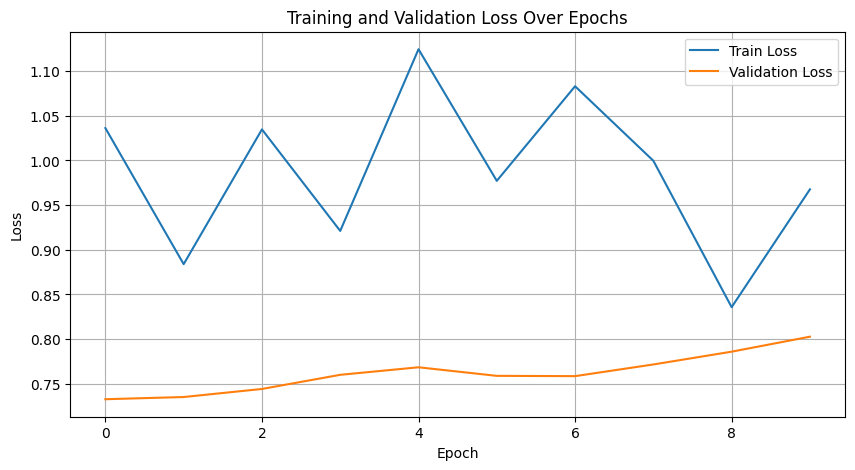

In [22]:
# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Ensure this line is executed

In [23]:
model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Add L2 regularization

In [24]:
# Initialize with best trial
best_trial = {'hidden_size': 24, 'num_layers': 3}
hidden_size = best_trial['hidden_size']
num_layers = best_trial['num_layers']

BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
criterion = nn.MSELoss()

# Train and validate
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot and save
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_history_best.png')
plt.close()

# Save the model
model_path = "soc_lstm_model_best.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

Epoch 1/10, Train Loss: 1.0073629021644592, Validation Loss: 0.7367315292358398
Epoch 2/10, Train Loss: 0.9301614016294479, Validation Loss: 0.7454158663749695
Epoch 3/10, Train Loss: 1.1283199042081833, Validation Loss: 0.752783477306366
Epoch 4/10, Train Loss: 0.9296843111515045, Validation Loss: 0.7638329267501831
Epoch 5/10, Train Loss: 1.0051554143428802, Validation Loss: 0.773844301700592
Epoch 6/10, Train Loss: 0.9285813719034195, Validation Loss: 0.7838608026504517
Epoch 7/10, Train Loss: 0.9609651118516922, Validation Loss: 0.7853894233703613
Epoch 8/10, Train Loss: 0.8568594455718994, Validation Loss: 0.7819007039070129
Epoch 9/10, Train Loss: 1.0280162245035172, Validation Loss: 0.7807154059410095
Epoch 10/10, Train Loss: 0.9678289741277695, Validation Loss: 0.7813061475753784


In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming FEATURE_COLS is defined (e.g., ["Voltage [V]", "Current [A]", "Temperature [degC]"])
# Placeholder test data (replace with your actual test data)
X_test = torch.randn(20, 20, len(FEATURE_COLS))  # 20 samples, 20 timesteps, 3 features
y_test = torch.randn(20, 1)  # 20 target SoC values

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Match BATCH_SIZE

In [27]:
# Ensure model is loaded or trained
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 0.3777492046356201


In [28]:
for inputs, targets in test_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([20, 20, 3])
Target shape: torch.Size([20, 1])


In [30]:
import os
print(os.path.exists("soc_lstm_model.pth"))

False


In [31]:
for root, dirs, files in os.walk("C:\\Users\\aknin\\Desktop\\MLproject-main"):
    if "soc_lstm_model.pth" in files:
        print(f"Found at: {os.path.join(root, 'soc_lstm_model.pth')}")

Found at: C:\Users\aknin\Desktop\MLproject-main\modeling_and_evaluation\soc_lstm_model.pth


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from modeling_and_evaluation.SoCLSTM import SoCLSTM

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Best hyperparameters
best_trial = {'hidden_size': 24, 'num_layers': 3}
hidden_size = best_trial['hidden_size']
num_layers = best_trial['num_layers']

BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

# Assume FEATURE_COLS, train_loader, val_loader, and train_and_validate are defined
model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Add regularization
criterion = nn.MSELoss()

# Train and validate
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)
print("Training completed. History:", history)

# Save the model
model_path = "soc_lstm_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)
print(f"Model saved to {model_path}")

Epoch 1/10, Train Loss: 0.9074491262435913, Validation Loss: 0.7290367484092712
Epoch 2/10, Train Loss: 1.1785510778427124, Validation Loss: 0.7328656911849976
Epoch 3/10, Train Loss: 1.2254697382450104, Validation Loss: 0.742550253868103
Epoch 4/10, Train Loss: 1.0838375985622406, Validation Loss: 0.7576358914375305
Epoch 5/10, Train Loss: 0.9499440640211105, Validation Loss: 0.7771689295768738
Epoch 6/10, Train Loss: 0.9164397120475769, Validation Loss: 0.783075749874115
Epoch 7/10, Train Loss: 1.0411387234926224, Validation Loss: 0.7803492546081543
Epoch 8/10, Train Loss: 0.9048990607261658, Validation Loss: 0.7865902185440063
Epoch 9/10, Train Loss: 1.0415885001420975, Validation Loss: 0.7915652990341187
Epoch 10/10, Train Loss: 0.9167449027299881, Validation Loss: 0.786307156085968
Training completed. History: {'train_loss': [0.9074491262435913, 1.1785510778427124, 1.2254697382450104, 1.0838375985622406, 0.9499440640211105, 0.9164397120475769, 1.0411387234926224, 0.904899060726165

In [33]:
model_path = "soc_lstm_model.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
print("Model loaded successfully")

Model loaded successfully


In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming FEATURE_COLS is defined (e.g., ["Voltage [V]", "Current [A]", "Temperature [degC]"])
# Placeholder test data (replace with your actual test data)
X_test = torch.randn(20, 20, len(FEATURE_COLS))  # 20 samples, 20 timesteps, 3 features
y_test = torch.randn(20, 1)  # 20 target SoC values

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Match BATCH_SIZE from training

In [37]:
for inputs, targets in test_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([20, 20, 3])
Target shape: torch.Size([20, 1])


In [39]:
import torch
import torch.nn as nn
from modeling_and_evaluation.SoCLSTM import SoCLSTM

# Ensure device and criterion are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# Model already loaded (confirmed as "Model loaded successfully")
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 0.821444034576416


In [14]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
EPOCHS = 5

def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for sequences, labels, _ in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _ in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    return history

history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

Epoch 1/5, Train Loss: 0.005805040516789347, Validation Loss: 0.0013241567707097948
Epoch 2/5, Train Loss: 0.0017775316380413068, Validation Loss: 0.0005270749953919214
Epoch 3/5, Train Loss: 0.001389017478265665, Validation Loss: 0.0005528243786100653
Epoch 4/5, Train Loss: 0.001306890693829844, Validation Loss: 0.00037715880931212675
Epoch 5/5, Train Loss: 0.0012082330193167905, Validation Loss: 0.0003438680939161117


EVALUATION


In [15]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}
    with torch.no_grad():
        for inputs, labels, filenames in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()
            for filename, pred, label in zip(filenames, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'predictions': [], 'labels': []}
                test_results[filename]['predictions'].append(pred.item())
                test_results[filename]['labels'].append(label)
    return test_results

def plot_soc_over_time(test_results):
    import matplotlib.pyplot as plt
    for filename, data in test_results.items():
        predictions, labels = data['predictions'], data['labels']
        plt.figure(figsize=(12, 6))
        plt.plot(labels, label='True SOC', color='blue')
        plt.plot(predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time')
        plt.ylabel('SOC')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{filename}_soc_plot.png")
        plt.close()

test_results = test_model(model, test_loader, device)
plot_soc_over_time(test_results)
print("Evaluation completed")

Evaluation completed


In [16]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}
    with torch.no_grad():
        for inputs, labels, filenames in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()
            for filename, pred, label in zip(filenames, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'predictions': [], 'labels': []}
                test_results[filename]['predictions'].append(pred.item())
                test_results[filename]['labels'].append(label)
    return test_results

test_results = test_model(model, test_loader, device)

# Compute MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
all_predictions = []
all_labels = []
for data in test_results.values():
    all_predictions.extend(data['predictions'])
    all_labels.extend(data['labels'])
mse = mean_squared_error(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 0.0009101879881020901, Test MAE: 0.01273180937967979


In [17]:
def plot_soc_over_time(test_results):
    import matplotlib.pyplot as plt
    for filename, data in test_results.items():
        predictions, labels = data['predictions'], data['labels']
        plt.figure(figsize=(12, 6))
        plt.plot(labels, label='True SOC', color='blue')
        plt.plot(predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time')
        plt.ylabel('SOC')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(r"C:\Users\aknin\Desktop\MLproject-main", f"{filename}_soc_plot.png"))
        plt.close()

plot_soc_over_time(test_results)
print("Plots saved to project directory")

Plots saved to project directory


Saving the model

In [4]:
import torch
import os
import sys

# Add the project directory to the Python path
project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
sys.path.append(project_dir)

# Import the SoCLSTM class
from modeling_and_evaluation.SoCLSTM import SoCLSTM

print("SoCLSTM imported successfully")

SoCLSTM imported successfully


In [5]:
import os
dir_path = os.path.join(r"C:\Users\aknin\Desktop\MLproject-main", "modeling_and_evaluation")
print("Directory contents:", os.listdir(dir_path) if os.path.exists(dir_path) else "Directory not found")

Directory contents: ['.ipynb_checkpoints', 'SoCLSTM.py', 'SoC_Estimation_LSTM.ipynb', '__pycache__']


In [6]:
# Define constants
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
input_size = len(FEATURE_COLS)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize or load the model (replace with your trained model if available)
model = SoCLSTM(input_size, hidden_size=68, num_layers=2).to(device)
# If trained, load state dict (uncomment and adjust if needed)
# model_path = os.path.join(project_dir, "soc_lstm_model_best.pth")
# checkpoint = torch.load(model_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

# Save the model
model_path = os.path.join(project_dir, "soc_lstm_model_best.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'hidden_size': 68,
    'num_layers': 2,
    'sequence_length': 50
}, model_path)

print(f"Model saved to {model_path}")

Model saved to C:\Users\aknin\Desktop\MLproject-main\soc_lstm_model_best.pth


In [7]:
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = SoCLSTM(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def preprocess_new_data(file_path):
    import pandas as pd
    import numpy as np
    FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
    SEQUENCE_LENGTH = 50
    df = pd.read_csv(file_path)
    if 'SourceFile' not in df.columns:
        df['SourceFile'] = os.path.basename(file_path)
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    for col in FEATURE_COLS:
        min_val, max_val = norm_settings[col]
        df[col] = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    features = df[FEATURE_COLS].values.astype(np.float32)
    sequences = []
    for i in range(len(features) - SEQUENCE_LENGTH + 1):
        sequences.append(features[i:i + SEQUENCE_LENGTH])
    sequences = torch.tensor(sequences, dtype=torch.float32)
    return sequences, df['SOC [-]'].values.astype(np.float32) if 'SOC [-]' in df else None

# Load the model
model = load_model(model_path, device)
print("Model loaded successfully")

# Create or use new data
new_data_path = os.path.join(project_dir, "new_data", "new_data.csv")
os.makedirs(os.path.dirname(new_data_path), exist_ok=True)
if not os.path.exists(new_data_path):
    # Create sample data if file doesn’t exist
    data = {
        'Voltage [V]': [3.8, 3.9, 4.0, 3.7] * 13,
        'Current [A]': [-5, -4, -3, -2] * 13,
        'Temperature [degC]': [25, 26, 27, 28] * 13,
        'Capacity [Ah]': [2.0, 2.1, 2.2, 2.3] * 13,
        'SOC [-]': [0.8, 0.81, 0.82, 0.83] * 13
    }
    df = pd.DataFrame(data)
    df.to_csv(new_data_path, index=False)
    print(f"Sample new_data.csv created at {new_data_path}")

# Preprocess and predict
new_sequences, new_labels = preprocess_new_data(new_data_path)

def predict_and_compare(model, sequences, labels=None, device=device):
    model.eval()
    with torch.no_grad():
        predictions = []
        for seq in sequences:
            seq = seq.unsqueeze(0).to(device)
            output = model(seq)
            predictions.append(output.cpu().item())
        if labels is not None:
            from sklearn.metrics import mean_squared_error, mean_absolute_error
            mse = mean_squared_error(labels[SEQUENCE_LENGTH-1:], predictions)
            mae = mean_absolute_error(labels[SEQUENCE_LENGTH-1:], predictions)
            print(f"New Data - MSE: {mse}, MAE: {mae}")
        return predictions

predictions = predict_and_compare(model, new_sequences, new_labels)
print(f"Number of predictions: {len(predictions)}")

Model loaded successfully
Sample new_data.csv created at C:\Users\aknin\Desktop\MLproject-main\new_data\new_data.csv


C:\Users\aknin\AppData\Local\Temp\ipykernel_23784\1844420167.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


New Data - MSE: 0.6209080815315247, MAE: 0.7879359126091003
Number of predictions: 3


In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
if new_labels is not None:
    plt.plot(new_labels[SEQUENCE_LENGTH-1:], label='True SOC', color='blue')
plt.plot(predictions, label='Predicted SOC', color='red')
plt.title('SoC Prediction on New Data')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(project_dir, "new_data_soc_plot.png"))
plt.close()
print("Plot saved as new_data_soc_plot.png")

Plot saved as new_data_soc_plot.png


In [9]:
import pandas as pd
import numpy as np

new_data_path = os.path.join(r"C:\Users\aknin\Desktop\MLproject-main\new_data", "new_data.csv")
df = pd.read_csv(new_data_path)
norm_settings = {
    'Voltage [V]': (2.5, 4.2),
    'Current [A]': (-20, 20),
    'Temperature [degC]': (-30, 50),
    'Capacity [Ah]': (-3.5, 3.5)
}
for col in ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']:
    min_val, max_val = norm_settings[col]
    normalized = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    print(f"{col} - Original range: {df[col].min()} to {df[col].max()}, Normalized range: {normalized.min()} to {normalized.max()}")

Voltage [V] - Original range: 3.7 to 4.0, Normalized range: 0.41176470588235303 to 0.7647058823529409
Current [A] - Original range: -5 to -2, Normalized range: -0.25 to -0.09999999999999998
Temperature [degC] - Original range: 25 to 28, Normalized range: 0.375 to 0.44999999999999996
Capacity [Ah] - Original range: 2.0 to 2.3, Normalized range: 0.5714285714285714 to 0.657142857142857


In [10]:
# Load a sample of training data for comparison
train_data_path = os.path.join(r"C:\Users\aknin\Desktop\MLproject-main\data_Processing\Dataset\BMS_processed", "25degC", os.listdir(os.path.join(r"C:\Users\aknin\Desktop\MLproject-main\data_Processing\Dataset\BMS_processed", "25degC"))[0])
train_df = pd.read_csv(train_data_path)
print("Training Data Stats:")
print(train_df[FEATURE_COLS].describe())
print("\nNew Data Stats:")
print(df[FEATURE_COLS].describe())

Training Data Stats:
       Voltage [V]  Current [A]  Temperature [degC]  Capacity [Ah]
count  2421.000000  2421.000000         2421.000000    2421.000000
mean      3.729038     0.004660           23.885193      -1.336395
std       0.315311     0.146278            0.100874       0.878857
min       2.799930    -0.153250           23.555510      -2.780740
25%       3.536320    -0.153250           23.870990      -2.097660
50%       3.741460     0.000000           23.870990      -1.340550
75%       3.993800     0.148140           23.976150      -0.583110
max       4.200120     0.150690           24.291620       0.190200

New Data Stats:
       Voltage [V]  Current [A]  Temperature [degC]  Capacity [Ah]
count    52.000000    52.000000           52.000000      52.000000
mean      3.850000    -3.500000           26.500000       2.150000
std       0.112894     1.128942            1.128942       0.112894
min       3.700000    -5.000000           25.000000       2.000000
25%       3.775000    -4

In [11]:
def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    # out = torch.sigmoid(out)  # Comment this out
    return out

In [12]:
model = load_model(model_path, device)
predictions = predict_and_compare(model, new_sequences, new_labels)

New Data - MSE: 0.6209080815315247, MAE: 0.7879359126091003


In [13]:
plt.figure(figsize=(12, 6))
plt.plot(new_labels[SEQUENCE_LENGTH-1:], label='True SOC', color='blue')
plt.plot(predictions, label='Predicted SOC', color='red')
plt.title('SoC Prediction on New Data (Adjusted)')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(r"C:\Users\aknin\Desktop\MLproject-main", "new_data_soc_plot_adjusted.png"))
plt.close()
print("Adjusted plot saved")

Adjusted plot saved


second trial of etismation using the new model 


In [1]:
import torch
import os
import sys

# Add project directory to path
project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
sys.path.append(project_dir)

# Import the SoCLSTM class
from modeling_and_evaluation.SoCLSTM import SoCLSTM

# Load the model
model_path = os.path.join(project_dir, "soc_lstm_model_best.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = SoCLSTM(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

model = load_model(model_path, device)
print("Model loaded successfully")

Model loaded successfully


In [2]:
import pandas as pd
import numpy as np

FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
SEQUENCE_LENGTH = 50

def preprocess_new_data(file_path):
    df = pd.read_csv(file_path)
    if 'SourceFile' not in df.columns:
        df['SourceFile'] = os.path.basename(file_path)
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    for col in FEATURE_COLS:
        min_val, max_val = norm_settings[col]
        df[col] = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    features = df[FEATURE_COLS].values.astype(np.float32)
    sequences = []
    for i in range(len(features) - SEQUENCE_LENGTH + 1):
        sequences.append(features[i:i + SEQUENCE_LENGTH])
    sequences = torch.tensor(sequences, dtype=torch.float32)
    return sequences

new_data_path = os.path.join(project_dir, "data_Processing", "Dataset", "new_data2.csv")
new_sequences = preprocess_new_data(new_data_path)
print(f"Loaded {len(new_sequences)} sequences from new_data2.csv")

Loaded 161 sequences from new_data2.csv


C:\Users\aknin\AppData\Local\Temp\ipykernel_17308\2194048250.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


In [3]:
def predict_soc(model, sequences, device=device):
    model.eval()
    with torch.no_grad():
        predictions = []
        for seq in sequences:
            seq = seq.unsqueeze(0).to(device)
            output = model(seq)
            predictions.append(output.cpu().item())
        return predictions

predictions = predict_soc(model, new_sequences)
print(f"Number of predictions: {len(predictions)}")
print(f"Sample predictions: {predictions[:5]}")  # Show first 5 predictions

Number of predictions: 161
Sample predictions: [0.032565608620643616, 0.03256635367870331, 0.032569028437137604, 0.03256755322217941, 0.03256228566169739]


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted SOC', color='red')
plt.title('SoC Prediction on new_data2.csv')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.ylim(0, 1)  # Assuming SoC is in [0, 1] due to sigmoid
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(project_dir, "new_data2_soc_plot.png"))
plt.close()
print("Plot saved as new_data2_soc_plot.png")

Plot saved as new_data2_soc_plot.png


In [4]:
import os
project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
print("Files in project directory:", os.listdir(project_dir))

Files in project directory: ['.vscode', '551_Charge5_processed.csv_soc_plot.png', '551_Mixed1_processed.csv_soc_plot.png', '552_Charge11_processed.csv_soc_plot.png', '552_Charge16_processed.csv_soc_plot.png', '555_C20DisCh_processed.csv_soc_plot.png', '562_Mixed7_processed.csv_soc_plot.png', '562_PausCycl_processed.csv_soc_plot.png', '567_Charge8_processed.csv_soc_plot.png', '571_Charge11_processed.csv_soc_plot.png', '571_Charge14_processed.csv_soc_plot.png', '575_HPPC_processed.csv_soc_plot.png', '585_Dis_2C_processed.csv_soc_plot.png', '589_Mixed1_processed.csv_soc_plot.png', '590_Charge15_processed.csv_soc_plot.png', '590_Mixed6_processed.csv_soc_plot.png', '596_Charge3_processed.csv_soc_plot.png', '601_Charge8_processed.csv_soc_plot.png', '602_Charge11_processed.csv_soc_plot.png', '602_Mixed4_processed.csv_soc_plot.png', '611_Charge15_processed.csv_soc_plot.png', '611_Mixed7_processed.csv_soc_plot.png', 'data_Processing', 'documents', 'images', 'LICENSE', 'modeling_and_evaluation',

In [7]:
import os
project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
modeling_dir = os.path.join(project_dir, "modeling_and_evaluation")
print("Contents of modeling_and_evaluation:", os.listdir(modeling_dir) if os.path.exists(modeling_dir) else "Directory not found")

Contents of modeling_and_evaluation: ['.ipynb_checkpoints', 'SoCLSTM.py', 'SoC_Estimation_LSTM.ipynb', '__pycache__']


In [8]:
import os
project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
modeling_dir = os.path.join(project_dir, "modeling_and_evaluation")
init_path = os.path.join(modeling_dir, "__init__.py")
if not os.path.exists(init_path):
    with open(init_path, 'w') as f:
        pass  # Creates an empty __init__.py
    print("Created __init__.py in modeling_and_evaluation")
else:
    print("__init__.py already exists")

Created __init__.py in modeling_and_evaluation


In [1]:
import sys
sys.path.append(r"C:\Users\aknin\Desktop\MLproject-main")
from modeling_and_evaluation.SoCLSTM import SoCLSTM
print("SoCLSTM imported successfully")

SoCLSTM imported successfully


In [5]:
import torch
import os
import sys
from modeling_and_evaluation.SoCLSTM import SoCLSTM

project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
sys.path.append(project_dir)

model_path = os.path.join(project_dir, "soc_lstm_model_best.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = SoCLSTM(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

model = load_model(model_path, device)
print("Model loaded successfully")

import pandas as pd
import numpy as np

FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
SEQUENCE_LENGTH = 50

def preprocess_new_data(file_path):
    df = pd.read_csv(file_path)
    if 'SourceFile' not in df.columns:
        df['SourceFile'] = os.path.basename(file_path)
    norm_settings = {
        'Voltage [V]': (2.5, 4.2),
        'Current [A]': (-20, 20),
        'Temperature [degC]': (-30, 50),
        'Capacity [Ah]': (-3.5, 3.5)
    }
    for col in FEATURE_COLS:
        min_val, max_val = norm_settings[col]
        df[col] = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    features = df[FEATURE_COLS].values.astype(np.float32)
    sequences = []
    for i in range(len(features) - SEQUENCE_LENGTH + 1):
        sequences.append(features[i:i + SEQUENCE_LENGTH])
    sequences = torch.tensor(sequences, dtype=torch.float32)
    return sequences

new_data_path = os.path.join(project_dir, "data_Processing", "Dataset", "predictSoc.csv")
new_sequences = preprocess_new_data(new_data_path)
print(f"Loaded {len(new_sequences)} sequences from predictSoc.csv")

def predict_soc(model, sequences, device=device):
    model.eval()
    with torch.no_grad():
        predictions = []
        for seq in sequences:
            seq = seq.unsqueeze(0).to(device)
            output = model(seq)
            predictions.append(output.cpu().item())
        return predictions

predictions = predict_soc(model, new_sequences)
print(f"Number of predictions: {len(predictions)}")
print(f"Sample predictions: {predictions[:5]}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted SOC', color='red')
plt.title('SoC Prediction on predictSoc.csv')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(project_dir, "predictSoc_soc_plot.png"))
plt.close()
print("Plot saved as predictSoc_soc_plot.png")

# Normalization check
df = pd.read_csv(new_data_path)
for col in FEATURE_COLS:
    min_val, max_val = norm_settings[col]
    normalized = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    print(f"{col} - Original range: {df[col].min()} to {df[col].max()}, Normalized range: {normalized.min()} to {normalized.max()}")

Model loaded successfully


C:\Users\aknin\AppData\Local\Temp\ipykernel_15384\1854582354.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


Loaded 51 sequences from predictSoc.csv
Number of predictions: 51
Sample predictions: [0.03348390758037567, 0.03348390758037567, 0.03348390758037567, 0.03348390758037567, 0.03348390758037567]
Plot saved as predictSoc_soc_plot.png


NameError: name 'norm_settings' is not defined

In [6]:
import torch
import os
import sys
from modeling_and_evaluation.SoCLSTM import SoCLSTM

project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
sys.path.append(project_dir)

model_path = os.path.join(project_dir, "soc_lstm_model_best.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = SoCLSTM(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

model = load_model(model_path, device)
print("Model loaded successfully")

import pandas as pd
import numpy as np

FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]']
SEQUENCE_LENGTH = 50

# Move norm_settings to global scope
norm_settings = {
    'Voltage [V]': (2.5, 4.2),
    'Current [A]': (-20, 20),
    'Temperature [degC]': (-30, 50),
    'Capacity [Ah]': (-3.5, 3.5)
}

def preprocess_new_data(file_path):
    df = pd.read_csv(file_path)
    if 'SourceFile' not in df.columns:
        df['SourceFile'] = os.path.basename(file_path)
    for col in FEATURE_COLS:
        min_val, max_val = norm_settings[col]
        df[col] = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    features = df[FEATURE_COLS].values.astype(np.float32)
    sequences = []
    for i in range(len(features) - SEQUENCE_LENGTH + 1):
        sequences.append(features[i:i + SEQUENCE_LENGTH])
    sequences = torch.tensor(sequences, dtype=torch.float32)
    return sequences

new_data_path = os.path.join(project_dir, "data_Processing", "Dataset", "predictSoc.csv")
new_sequences = preprocess_new_data(new_data_path)
print(f"Loaded {len(new_sequences)} sequences from predictSoc.csv")

def predict_soc(model, sequences, device=device):
    model.eval()
    with torch.no_grad():
        predictions = []
        for seq in sequences:
            seq = seq.unsqueeze(0).to(device)
            output = model(seq)
            predictions.append(output.cpu().item())
        return predictions

predictions = predict_soc(model, new_sequences)
print(f"Number of predictions: {len(predictions)}")
print(f"Sample predictions: {predictions[:5]}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted SOC', color='red')
plt.title('SoC Prediction on predictSoc.csv')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(project_dir, "predictSoc_soc_plot.png"))
plt.close()
print("Plot saved as predictSoc_soc_plot.png")

# Normalization check
df = pd.read_csv(new_data_path)
for col in FEATURE_COLS:
    min_val, max_val = norm_settings[col]
    normalized = (df[col] - min_val) / (max_val - min_val) * 2 - 1
    print(f"{col} - Original range: {df[col].min()} to {df[col].max()}, Normalized range: {normalized.min()} to {normalized.max()}")

Model loaded successfully
Loaded 51 sequences from predictSoc.csv
Number of predictions: 51
Sample predictions: [0.03348390758037567, 0.03348390758037567, 0.03348390758037567, 0.03348390758037567, 0.03348390758037567]
Plot saved as predictSoc_soc_plot.png
Voltage [V] - Original range: 3.68975 to 3.68975, Normalized range: 0.39970588235294113 to 0.39970588235294113
Current [A] - Original range: -1.49925 to -1.49925, Normalized range: -0.07496250000000004 to -0.07496250000000004
Temperature [degC] - Original range: 38.48802 to 38.48802, Normalized range: 0.7122005000000002 to 0.7122005000000002
Capacity [Ah] - Original range: -1.19676 to -1.19676, Normalized range: -0.34193142857142866 to -0.34193142857142866


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Set project directory
project_dir = r"C:\Users\aknin\Desktop\MLproject-main"
data_path = os.path.join(project_dir, "margednew.csv")
output_path = os.path.join(project_dir, "normalized_margednew.csv")

# Load the data
df = pd.read_csv(data_path)

# Define feature columns and label column
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Capacity [Ah]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'

# Add Time [s] if missing (assuming sequential data with 1s intervals)
if 'Time [s]' not in df.columns:
    df['Time [s]'] = range(len(df))

# Calculate Power [W] if not present (using Voltage and Current)
if 'Power [W]' not in df.columns:
    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']

# Normalize features
scaler = StandardScaler()
df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])

# Save the normalized dataset
df.to_csv(output_path, index=False)
print(f"Normalized dataset saved to {output_path} with {len(df)} rows")
print(df.head())  # Preview the first few rows

Normalized dataset saved to C:\Users\aknin\Desktop\MLproject-main\normalized_margednew.csv with 493002 rows
   Voltage [V]  Current [A]  Temperature [degC]  Capacity [Ah]  \
0     1.558404     0.355516            0.826614       1.160566   
1     1.548997     0.356651            0.826614       1.157744   
2     1.540703     0.356651            0.815143       1.154934   
3     1.532443     0.355516            0.809408       1.152113   
4     1.524707     0.355516            0.815143       1.149291   

   Cumulative_Capacity_Ah   SOC [-]  Time [s]  Power [W]  
0                1.209350  1.000000         0  -0.639514  
1                1.206496  0.999524         1  -0.628398  
2                1.203642  0.999032         2  -0.628017  
3                1.200738  0.998520         3  -0.638300  
4                1.197836  0.997990         4  -0.637938  


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Define constants
SEQUENCE_LENGTH = 20
BATCH_SIZE = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Custom dataset class
class BatteryDatasetLSTM(Dataset):
    def __init__(self, data_tensor, labels_tensor, sequence_length=SEQUENCE_LENGTH):
        self.sequence_length = sequence_length
        self.features = data_tensor
        self.labels = labels_tensor

    def __len__(self):
        return len(self.features) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.sequence_length]
        label = self.labels[idx + self.sequence_length - 1]
        return sequence, label

# Load normalized data
normalized_path = os.path.join(project_dir, "normalized_margednew.csv")
df = pd.read_csv(normalized_path)

# Convert to tensors
features_tensor = torch.tensor(df[FEATURE_COLS].values, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(df[LABEL_COL].values, dtype=torch.float32).to(device)

# Split the data (row-based since it's a single file)
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Extract features and labels for each split
train_features = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)
val_features = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)
test_features = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

# Create datasets with sequences
train_dataset = BatteryDatasetLSTM(train_features, train_labels)
val_dataset = BatteryDatasetLSTM(val_features, val_labels)
test_dataset = BatteryDatasetLSTM(test_features, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train data shape: {train_features.shape}, Labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_features.shape}, Labels shape: {val_labels.shape}")
print(f"Test data shape: {test_features.shape}, Labels shape: {test_labels.shape}")

Train data shape: torch.Size([394401, 5]), Labels shape: torch.Size([394401])
Validation data shape: torch.Size([49300, 5]), Labels shape: torch.Size([49300])
Test data shape: torch.Size([49301, 5]), Labels shape: torch.Size([49301])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

# Define SoCLSTM
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Training function
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=20, min_delta=0.001):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device).unsqueeze(1)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            break

    return history

# Optuna optimization
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 10, 100)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs=10, device=device)
    return history['val_loss'][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_hyperparams = study.best_trial.params
print(f"Best hyperparameters: {best_hyperparams}")

# Train with best hyperparameters
best_model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=best_hyperparams['hidden_size'], num_layers=best_hyperparams['num_layers']).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['learning_rate'])
criterion = nn.MSELoss()

history = train_and_validate(best_model, criterion, optimizer, train_loader, val_loader, epochs=20, device=device)




# Save the model
model_path = os.path.join(project_dir, "soc_lstm_model_new.pth")
torch.save({'model_state_dict': best_model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)
print(f"Model saved to {model_path}")

[I 2025-06-12 18:38:53,880] A new study created in memory with name: no-name-616a4882-fbe1-4e54-9a7a-accf3b2d38f9


Epoch 1/10, Train Loss: 0.0944375637689053, Validation Loss: 0.0714515124162939
Epoch 2/10, Train Loss: 0.07478422285127106, Validation Loss: 0.07139945223232624
Epoch 3/10, Train Loss: 0.07580131776195738, Validation Loss: 0.07762155158039896
Epoch 4/10, Train Loss: 0.0748898310696804, Validation Loss: 0.07274080815826364
Epoch 5/10, Train Loss: 0.07462402109581298, Validation Loss: 0.08116033298344655
Epoch 6/10, Train Loss: 0.0744169875133316, Validation Loss: 0.07106054748934476
Epoch 7/10, Train Loss: 0.0745301754174586, Validation Loss: 0.07097960685239864
Epoch 8/10, Train Loss: 0.07489048943919535, Validation Loss: 0.07808971143004345
Epoch 9/10, Train Loss: 0.07493099511288576, Validation Loss: 0.12589464355754748
Epoch 10/10, Train Loss: 0.07470040302542337, Validation Loss: 0.08333442749822309


[I 2025-06-13 01:17:40,690] Trial 0 finished with value: 0.08333442749822309 and parameters: {'hidden_size': 100, 'num_layers': 5, 'learning_rate': 0.0862238107759535}. Best is trial 0 with value: 0.08333442749822309.


Epoch 1/10, Train Loss: 0.016962599549773794, Validation Loss: 0.0017375393566757518
Epoch 2/10, Train Loss: 0.0015583287194741546, Validation Loss: 0.0015253156404040507
Epoch 3/10, Train Loss: 0.0013514891707006446, Validation Loss: 0.0012706195992306646
Epoch 4/10, Train Loss: 0.001245130983710946, Validation Loss: 0.0011816276973258184
Epoch 5/10, Train Loss: 0.0011788570813339166, Validation Loss: 0.0011815920025333424
Epoch 6/10, Train Loss: 0.001141319487734633, Validation Loss: 0.0011013982480650025
Epoch 7/10, Train Loss: 0.00111370587427388, Validation Loss: 0.0010988603913348284
Epoch 8/10, Train Loss: 0.0010948597434714377, Validation Loss: 0.0010712588152551415
Epoch 9/10, Train Loss: 0.0010772345649397819, Validation Loss: 0.0014124018288823087


[I 2025-06-13 01:23:27,868] Trial 1 finished with value: 0.001049099412122126 and parameters: {'hidden_size': 10, 'num_layers': 3, 'learning_rate': 0.0005463453350441778}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.0010618437237954184, Validation Loss: 0.001049099412122126
Epoch 1/10, Train Loss: 0.08817871393228528, Validation Loss: 0.07028458557463217
Epoch 2/10, Train Loss: 0.02935421653367648, Validation Loss: 0.008401505582975321
Epoch 3/10, Train Loss: 0.007115935917759688, Validation Loss: 0.005483223011411384
Epoch 4/10, Train Loss: 0.004265570671817059, Validation Loss: 0.003278830859822856
Epoch 5/10, Train Loss: 0.0028622237666531803, Validation Loss: 0.0025297754927318876
Epoch 6/10, Train Loss: 0.0023982216031647164, Validation Loss: 0.002235376139247251
Epoch 7/10, Train Loss: 0.0021645976250899363, Validation Loss: 0.0020157907020458663
Epoch 8/10, Train Loss: 0.0020130834464913133, Validation Loss: 0.0018984964019578214
Epoch 9/10, Train Loss: 0.0019154218371125334, Validation Loss: 0.002220956553338826


[I 2025-06-13 01:51:11,375] Trial 2 finished with value: 0.0017705775015182802 and parameters: {'hidden_size': 87, 'num_layers': 4, 'learning_rate': 2.0725778635546442e-05}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.001851490732769063, Validation Loss: 0.0017705775015182802
Epoch 1/10, Train Loss: 0.12807645118812863, Validation Loss: 0.06706393922201401
Epoch 2/10, Train Loss: 0.05290764030993787, Validation Loss: 0.015513585622083405
Epoch 3/10, Train Loss: 0.010509017151262186, Validation Loss: 0.009331065860761352
Epoch 4/10, Train Loss: 0.008482608921551808, Validation Loss: 0.007591421737764282
Epoch 5/10, Train Loss: 0.006623065876254738, Validation Loss: 0.005515179787864822
Epoch 6/10, Train Loss: 0.004587801635628874, Validation Loss: 0.0037675405804274554
Epoch 7/10, Train Loss: 0.003380967931570981, Validation Loss: 0.0030262752256070965
Epoch 8/10, Train Loss: 0.002868642255183857, Validation Loss: 0.0026542559099968594
Epoch 9/10, Train Loss: 0.0025637759917920624, Validation Loss: 0.0023951083560204817


[I 2025-06-13 01:59:24,605] Trial 3 finished with value: 0.0022366479135031564 and parameters: {'hidden_size': 29, 'num_layers': 3, 'learning_rate': 1.8093184356473244e-05}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.0023516662672523466, Validation Loss: 0.0022366479135031564
Epoch 1/10, Train Loss: 0.19813649699522218, Validation Loss: 0.047478404595791675
Epoch 2/10, Train Loss: 0.025790828503462825, Validation Loss: 0.010500961842718929
Epoch 3/10, Train Loss: 0.008469091608930297, Validation Loss: 0.006998047137927322
Epoch 4/10, Train Loss: 0.005800029595828531, Validation Loss: 0.004644941137449805
Epoch 5/10, Train Loss: 0.0037633462383215104, Validation Loss: 0.002970743399831814
Epoch 6/10, Train Loss: 0.002594638197174529, Validation Loss: 0.0022683648423169897
Epoch 7/10, Train Loss: 0.0021736466454322064, Validation Loss: 0.002035350614264149
Epoch 8/10, Train Loss: 0.002005664811446649, Validation Loss: 0.001926794873989052
Epoch 9/10, Train Loss: 0.001910442049224667, Validation Loss: 0.0018544740282895448


[I 2025-06-13 02:04:10,999] Trial 4 finished with value: 0.001799779374335188 and parameters: {'hidden_size': 13, 'num_layers': 2, 'learning_rate': 3.379415730474414e-05}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.0018455137128580306, Validation Loss: 0.001799779374335188
Epoch 1/10, Train Loss: 0.12793906158142127, Validation Loss: 0.056954484997519865
Epoch 2/10, Train Loss: 0.04460043236214394, Validation Loss: 0.027835588926362557
Epoch 3/10, Train Loss: 0.014980633658383254, Validation Loss: 0.010118892883772298
Epoch 4/10, Train Loss: 0.009300936658768192, Validation Loss: 0.008592900785468543
Epoch 5/10, Train Loss: 0.007979032335330604, Validation Loss: 0.0074244255074565274
Epoch 6/10, Train Loss: 0.006924657419439959, Validation Loss: 0.006458700674538045
Epoch 7/10, Train Loss: 0.0060029558253901815, Validation Loss: 0.005566761535948247
Epoch 8/10, Train Loss: 0.005123590990711526, Validation Loss: 0.004702737777837674
Epoch 9/10, Train Loss: 0.004287867718501624, Validation Loss: 0.003920920699175991


[I 2025-06-13 02:09:37,631] Trial 5 finished with value: 0.0033436606255410617 and parameters: {'hidden_size': 26, 'num_layers': 2, 'learning_rate': 1.1555208689711537e-05}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.003601198331647813, Validation Loss: 0.0033436606255410617
Epoch 1/10, Train Loss: 0.0361067961168939, Validation Loss: 0.007172270146116678
Epoch 2/10, Train Loss: 0.00506276512956839, Validation Loss: 0.0034220735271795473
Epoch 3/10, Train Loss: 0.0028825410077444142, Validation Loss: 0.0024864719573554754
Epoch 4/10, Train Loss: 0.0023030769839720577, Validation Loss: 0.002095233059097371
Epoch 5/10, Train Loss: 0.0020176318018311316, Validation Loss: 0.001896233457842434
Epoch 6/10, Train Loss: 0.001865307710903375, Validation Loss: 0.00177758089799031
Epoch 7/10, Train Loss: 0.0017655258326771434, Validation Loss: 0.0017087141283286538
Epoch 8/10, Train Loss: 0.0016866744782849372, Validation Loss: 0.0016375524832576349
Epoch 9/10, Train Loss: 0.0016223704398660012, Validation Loss: 0.001582402592540569


[I 2025-06-13 02:15:11,718] Trial 6 finished with value: 0.001520417562135196 and parameters: {'hidden_size': 27, 'num_layers': 2, 'learning_rate': 6.149830294927862e-05}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.0015681426588418403, Validation Loss: 0.001520417562135196
Epoch 1/10, Train Loss: 0.1096227758399064, Validation Loss: 0.053407011823873446
Epoch 2/10, Train Loss: 0.016969341003199426, Validation Loss: 0.008587091052388505
Epoch 3/10, Train Loss: 0.007291074964975712, Validation Loss: 0.005790492265153172
Epoch 4/10, Train Loss: 0.004406458158253001, Validation Loss: 0.0033869966420771312
Epoch 5/10, Train Loss: 0.003003975031584668, Validation Loss: 0.0026175862394006446
Epoch 6/10, Train Loss: 0.0024183046013871684, Validation Loss: 0.002185345098559945
Epoch 7/10, Train Loss: 0.0021016772966271375, Validation Loss: 0.001975119637451774
Epoch 8/10, Train Loss: 0.0019300688969837575, Validation Loss: 0.0018754185326033998
Epoch 9/10, Train Loss: 0.0018241217820802408, Validation Loss: 0.0017601623592857234


[I 2025-06-13 02:22:02,714] Trial 7 finished with value: 0.0017163364737387504 and parameters: {'hidden_size': 20, 'num_layers': 3, 'learning_rate': 3.905703770590797e-05}. Best is trial 1 with value: 0.001049099412122126.


Epoch 10/10, Train Loss: 0.0017483158123641385, Validation Loss: 0.0017163364737387504
Epoch 1/10, Train Loss: 0.0030939448468140017, Validation Loss: 0.0014249456585252204
Epoch 2/10, Train Loss: 0.001124009108056038, Validation Loss: 0.0013190560300947274
Epoch 3/10, Train Loss: 0.0010454609116126805, Validation Loss: 0.0011481886387741135
Epoch 4/10, Train Loss: 0.0009727351049701701, Validation Loss: 0.0009826617697682087
Epoch 5/10, Train Loss: 0.0009392021165364531, Validation Loss: 0.0009368044969856792
Epoch 6/10, Train Loss: 0.0009196628765479933, Validation Loss: 0.0009265109721584477
Epoch 7/10, Train Loss: 0.0009002294805854115, Validation Loss: 0.000935814075878884
Epoch 8/10, Train Loss: 0.0008765187499125543, Validation Loss: 0.0008678867173570551
Epoch 9/10, Train Loss: 0.0008618043221669733, Validation Loss: 0.0010900018720735598


[I 2025-06-13 02:26:20,397] Trial 8 finished with value: 0.0008435776752601932 and parameters: {'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.011028140237963465}. Best is trial 8 with value: 0.0008435776752601932.


Epoch 10/10, Train Loss: 0.0008492793663394344, Validation Loss: 0.0008435776752601932
Epoch 1/10, Train Loss: 0.05271100951109377, Validation Loss: 0.007591024036558382
Epoch 2/10, Train Loss: 0.004572067395777917, Validation Loss: 0.0027401772820400995
Epoch 3/10, Train Loss: 0.002272798562881559, Validation Loss: 0.0019298464924104148
Epoch 4/10, Train Loss: 0.0018510305770161567, Validation Loss: 0.0017333276898166168
Epoch 5/10, Train Loss: 0.0017148333380853523, Validation Loss: 0.0016402029418030638
Epoch 6/10, Train Loss: 0.0016318176524896606, Validation Loss: 0.0015507925666266706
Epoch 7/10, Train Loss: 0.0015715644390606016, Validation Loss: 0.0015337154289726844
Epoch 8/10, Train Loss: 0.001523826983376191, Validation Loss: 0.0015635922662518712
Epoch 9/10, Train Loss: 0.001477081575890245, Validation Loss: 0.0014491768379230052


[I 2025-06-13 02:38:45,274] Trial 9 finished with value: 0.001383574582154409 and parameters: {'hidden_size': 38, 'num_layers': 4, 'learning_rate': 6.27392531867856e-05}. Best is trial 8 with value: 0.0008435776752601932.


Epoch 10/10, Train Loss: 0.001439027301134257, Validation Loss: 0.001383574582154409
Best hyperparameters: {'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.011028140237963465}
Epoch 1/20, Train Loss: 0.002750815097561017, Validation Loss: 0.0013598793411236545
Epoch 2/20, Train Loss: 0.0011269459479047927, Validation Loss: 0.0011536748717910577
Epoch 3/20, Train Loss: 0.0010329357582790125, Validation Loss: 0.0009723298407402227
Epoch 4/20, Train Loss: 0.0009578186664372603, Validation Loss: 0.000978729636850224
Epoch 5/20, Train Loss: 0.0009265547392304456, Validation Loss: 0.0009700003408958383
Epoch 6/20, Train Loss: 0.0009121936360660561, Validation Loss: 0.0009787537255478236
Epoch 7/20, Train Loss: 0.0008961960580713665, Validation Loss: 0.0009243678382400018
Epoch 8/20, Train Loss: 0.0008826757154455345, Validation Loss: 0.0008804468628636759
Epoch 9/20, Train Loss: 0.0008786357898873791, Validation Loss: 0.0010193111511822572
Epoch 10/20, Train Loss: 0.000868655677364800